In [1]:
import math
import time
from typing import Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



from numpy.random import default_rng
from numpy.linalg import svd
from time import perf_counter

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.utils.extmath import randomized_svd


In [286]:


# --- tqdm (progress bars) ---
try:
    from tqdm.auto import tqdm  # works in notebooks and terminal
except Exception:
    # Fallback: no-op if tqdm isn't available
    def tqdm(iterable=None, **kwargs):
        return iterable if iterable is not None else range(0)


# ------------------------
# Matplotlib style
# ------------------------

FIGSIZE = (6.0, 4.0)


def setup_matplotlib_style() -> None:
    """
    Set global Matplotlib rcParams for publication-quality plots.
    """
    try:
        plt.style.use("seaborn-v0_8-colorblind")
    except Exception:
        # Fallback to default if style not found
        pass

    plt.rcParams.update(
        {
            "figure.dpi": 120,
            "savefig.dpi": 300,
            "font.size": 11,
            "axes.titlesize": 12,
            "axes.labelsize": 11,
            "legend.fontsize": 9,
            "xtick.labelsize": 9,
            "ytick.labelsize": 9,
            "axes.grid": True,
            "grid.alpha": 0.3,
            "grid.linestyle": "--",
            "grid.linewidth": 0.8,
            "lines.linewidth": 2.0,
            "lines.markersize": 5,
            "figure.autolayout": True,
            # slightly thinner axes, no boxy top/right spines
            "axes.spines.top": False,
            "axes.spines.right": False,
        }
    )


# Apply global style once at import
setup_matplotlib_style()


def format_axes(ax: plt.Axes) -> None:
    """Apply consistent formatting to a single Axes."""
    ax.grid(True)


# ------------------------
# Utilities
# ------------------------


def sample_X_ar1(
    n: int,
    p: int,
    rho: float,
    rng: np.random.Generator,
    dtype=np.float64,
) -> np.ndarray:
    """
    Generate X with Toeplitz column-covariance Sigma_ij = rho^{|i-j|}
    by simulating p-length AR(1) sequences row-wise at stationarity.
    """
    X = np.zeros((n, p), dtype=dtype)
    sigma_eta = math.sqrt(1.0 - rho**2) if abs(rho) < 1 else 0.0
    X[:, 0] = rng.normal(0.0, 1.0, size=n)
    for j in range(1, p):
        eta = rng.normal(0.0, sigma_eta, size=n)
        X[:, j] = rho * X[:, j - 1] + eta
    return X


def col_standardize(X: np.ndarray) -> np.ndarray:
    """Column-standardize X to unit sample std (ddof=1)."""
    Xs = X.copy()
    std = Xs.std(axis=0, ddof=1)
    std[std == 0] = 1.0
    Xs /= std
    return Xs


def randomized_svd(
    X: np.ndarray,
    k: int,
    n_iter: int = 2,
    rng: np.random.Generator | None = None,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Compute top-k SVD using a randomized range finder (with small oversampling).
    Returns (U_k, S_k, Vt_k) with singular values sorted descending.
    """
    n, p = X.shape
    if rng is None:
        rng = np.random.default_rng()

    over = min(10, max(2, k // 5))
    q = min(k + over, min(n, p))

    Omega = rng.normal(0.0, 1.0, size=(p, q))  # (p x q)
    Y = X @ Omega  # (n x q)

    for _ in range(n_iter):
        Y = X @ (X.T @ Y)

    Q, _ = np.linalg.qr(Y, mode="reduced")  # (n x q)
    B = Q.T @ X  # (q x p)
    Ub, S, Vt = np.linalg.svd(B, full_matrices=False)
    U = Q @ Ub
    k_eff = min(k, len(S))
    return U[:, :k_eff], S[:k_eff], Vt[:k_eff, :]


# ------------------------
# Helpers for beta*, OLS, Ridge
# ------------------------


def make_beta_star(
    Vt: np.ndarray,
    kind: str = "poly-decay",
    decay_power: float = 1.0,
    sparse_k: int = 10,
    scale: float = 1.0,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Construct a 'true' coefficient vector beta_star and its coordinates in the
    right-singular-vector basis of X (rows of Vt).

    Returns
    -------
    beta_star : (p,) in the original coordinate system.
    beta_star_V : (r,) coordinates in the v_j basis.
    """
    r, p = Vt.shape

    if kind == "poly-decay":
        j = np.arange(1, r + 1, dtype=float)
        beta_V = j ** (-decay_power)
    elif kind == "sparse-topk":
        beta_V = np.zeros(r, dtype=float)
        k_use = min(sparse_k, r)
        beta_V[:k_use] = 1.0
    else:
        j = np.arange(1, r + 1, dtype=float)
        beta_V = j ** (-decay_power)

    # Normalize: ||beta_V||_2 = scale
    norm = np.linalg.norm(beta_V)
    if norm > 0:
        beta_V = (scale / norm) * beta_V

    beta = Vt.T @ beta_V  # (p,)
    return beta, beta_V


def ols_beta_from_svd(
    U: np.ndarray,
    S: np.ndarray,
    Vt: np.ndarray,
    y: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    OLS solution using (possibly truncated) SVD of X: X = U diag(S) V^T.
    beta_hat = V diag(1/S) U^T y.
    """
    coeffs_y = U.T @ y  # (r,)
    invS = np.zeros_like(S)
    nonzero = S > 1e-12
    invS[nonzero] = 1.0 / S[nonzero]
    beta_hat = Vt.T @ (invS * coeffs_y)  # (p,)
    return beta_hat, invS, coeffs_y


def ridge_beta_from_svd(
    U: np.ndarray,
    S: np.ndarray,
    Vt: np.ndarray,
    y: np.ndarray | None,
    lam: float,
    coeffs_y: np.ndarray | None = None,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Ridge solution using SVD: g_j(λ) = S_j / (S_j^2 + λ)
    beta_ridge = V diag(g(λ)) U^T y

    If coeffs_y is provided, we reuse it instead of recomputing U^T y.
    """
    if coeffs_y is None:
        if y is None:
            raise ValueError("Either y or coeffs_y must be provided.")
        coeffs_y = U.T @ y

    g = S / (S**2 + lam)
    beta_ridge = Vt.T @ (g * coeffs_y)
    return beta_ridge, g, coeffs_y


# ------------------------
# Nyström kernel helpers
# ------------------------


def rbf_kernel(X1: np.ndarray, X2: np.ndarray, lengthscale: float) -> np.ndarray:
    """RBF kernel: k(x,x') = exp(-||x-x'||^2 / (2ℓ^2))."""
    x1_sq = np.sum(X1**2, axis=1)[:, None]
    x2_sq = np.sum(X2**2, axis=1)[None, :]
    d2 = x1_sq + x2_sq - 2.0 * (X1 @ X2.T)
    return np.exp(-d2 / (2.0 * lengthscale**2))


def median_lengthscale(
    X: np.ndarray,
    rng: np.random.Generator,
    max_samples: int = 1000,
) -> float:
    """Median-distance heuristic for RBF lengthscale (on a subsample)."""
    s = min(max_samples, X.shape[0])
    idx = rng.choice(X.shape[0], size=s, replace=False)
    Xs = X[idx]

    x_sq = np.sum(Xs**2, axis=1)[:, None]
    d2 = x_sq + x_sq.T - 2.0 * (Xs @ Xs.T)
    tri = d2[np.triu_indices_from(d2, k=1)]
    med = np.median(np.sqrt(np.maximum(tri, 0.0)))
    return max(med, 1e-6)


def nystrom_features(
    X: np.ndarray,
    m: int,
    lengthscale: float,
    rng: np.random.Generator,
    jitter: float = 1e-8,
):
    """
    Nyström approximation for RBF kernel:

    - pick m landmarks
    - W = K_mm, C = K_nm
    - Z = C W^{-1/2}, so K_nys ≈ Z Z^T.

    Returns
    -------
    Z, Uz, Sz, Vtz, kappa, X_land, Winvhalf
    """
    n = X.shape[0]
    m_eff = min(m, n)
    landmark_idx = rng.choice(n, size=m_eff, replace=False)
    X_land = X[landmark_idx]

    W = rbf_kernel(X_land, X_land, lengthscale)
    evals, evecs = np.linalg.eigh(W + jitter * np.eye(m_eff))
    evals = np.maximum(evals, 1e-12)
    Winvhalf = evecs @ np.diag(1.0 / np.sqrt(evals)) @ evecs.T

    C = rbf_kernel(X, X_land, lengthscale)
    Z = C @ Winvhalf  # n x m_eff features

    Uz, Sz, Vtz = np.linalg.svd(Z, full_matrices=False)  # Z = Uz diag(Sz) Vz^T
    kappa = Sz**2  # eigenvalues of K_nys

    return Z, Uz, Sz, Vtz, kappa, X_land, Winvhalf


def nystrom_features_apply(
    Xnew: np.ndarray,
    X_land: np.ndarray,
    Winvhalf: np.ndarray,
    lengthscale: float,
) -> np.ndarray:
    """Apply learned Nyström features to new points."""
    Cnew = rbf_kernel(Xnew, X_land, lengthscale)
    return Cnew @ Winvhalf


# ------------------------
# Core ridge curves (no plotting, for single replicate)
# ------------------------


def ridge_curves_for_combo(
    X: np.ndarray,
    col_std: np.ndarray,
    U: np.ndarray,
    S: np.ndarray,
    Vt: np.ndarray,
    rng: np.random.Generator,
    rho: float,
    beta_type: str = "poly-decay",
    decay_power: float = 1.0,
    sparse_k: int = 10,
    sigma_eps: float = 0.5,
    grid_points: int = 60,
    lambda_grid: np.ndarray | None = None,
    num_dirs_each_side: int = 5,  # kept for compatibility, not used here
    n_test: int | None = None,
    use_kernel: bool = True,
    m_nystrom: int = 300,
    kernel_lengthscale: float | None = None,
    kernel_max_samples: int = 1000,
):
    """
    Compute ridge and (optional) kernel ridge risk quantities for a single
    (rho, n, p) combo, without any plotting.

    Returns
    -------
    dict with lambda_grid, aggregate bias/variance/MSE in the v_j basis,
    and test MSE curves for linear and kernel ridge.
    """
    n, p = X.shape
    r = len(S)

    if n_test is None:
        n_test = n

    # True beta in v_j basis
    beta_star, beta_star_V = make_beta_star(
        Vt,
        kind=beta_type,
        decay_power=decay_power,
        sparse_k=sparse_k,
        scale=1.0,
    )

    eps = rng.normal(0.0, sigma_eps, size=n)
    y = X @ beta_star + eps

    # Lambda grid
    if lambda_grid is None:
        lam_scale = S[0] ** 2 if len(S) > 0 else 1.0
        lambda_grid = lam_scale * np.logspace(-10, 2, grid_points)

    # --- Linear ridge: OLS + ridge filters ---
    beta_ols, invS, coeffs_y = ols_beta_from_svd(U, S, Vt, y)

    betas_ridge = []
    filters_ridge = []
    for lam in lambda_grid:
        # reuse coeffs_y (U^T y) across lambdas
        b_ridge, filt, _ = ridge_beta_from_svd(
            U, S, Vt, y=None, lam=lam, coeffs_y=coeffs_y
        )
        betas_ridge.append(b_ridge)
        filters_ridge.append(filt)

    betas_ridge = np.stack(betas_ridge, axis=0)  # (L, p)
    filters_ridge = np.stack(filters_ridge, axis=0)  # (L, r)

    # Bias–variance–MSE decomposition in v_j basis for each λ
    sigma2 = sigma_eps**2
    S2 = S**2

    Bias_j = []
    Var_j = []
    MSE_j = []

    for lam in lambda_grid:
        bias = -(lam / (S2 + lam)) * beta_star_V  # (r,)
        var = sigma2 * (S2 / (S2 + lam) ** 2)  # (r,)
        mse = bias**2 + var
        Bias_j.append(bias)
        Var_j.append(var)
        MSE_j.append(mse)

    Bias_j = np.stack(Bias_j)  # (L, r)
    Var_j = np.stack(Var_j)  # (L, r)
    MSE_j = np.stack(MSE_j)  # (L, r)

    agg_bias2 = np.sum(Bias_j**2, axis=1)
    agg_var = np.sum(Var_j, axis=1)
    agg_mse = np.sum(MSE_j, axis=1)

    # Prediction risk vs λ on a fresh test design (linear ridge)
    Xtest = sample_X_ar1(n_test, p, rho, rng, dtype=X.dtype)
    Xtest = Xtest / col_std
    ytest = Xtest @ beta_star + rng.normal(0.0, sigma_eps, size=n_test)

    test_mse_linear = []
    for k_idx in range(len(lambda_grid)):
        beta_ridge_k = betas_ridge[k_idx]
        yhat = Xtest @ beta_ridge_k
        test_mse_linear.append(np.mean((yhat - ytest) ** 2))
    test_mse_linear = np.array(test_mse_linear)

    # ------------------------
    # Nyström kernel ridge section (optional)
    # ------------------------
    agg_bias2_K = agg_var_K = agg_mse_K = None
    test_mse_kernel = df_kernel = None
    kappa = None
    nystrom_time = 0.0


    if use_kernel:
        t_nys0 = time.perf_counter()       
        # lengthscale via median heuristic if not provided
        if kernel_lengthscale is None:
            ell = median_lengthscale(X, rng, max_samples=kernel_max_samples)
        else:
            ell = kernel_lengthscale

        m = min(m_nystrom, n)
        Z, Uz, Sz, Vtz, kappa, X_land, Winvhalf = nystrom_features(X, m, ell, rng)

        # Kernel ridge via Z-SVD (cheap across λ)
        uy = Uz.T @ y  # training outputs in kernel eigenbasis
        f_star = X @ beta_star  # noiseless target under linear DGP
        f_star_eig = Uz.T @ f_star

        sigma2 = sigma_eps**2

        df_kernel_list = []
        test_mse_kernel_list = []

        BiasK_j = []
        VarK_j = []
        MSEK_j = []

        # Precompute Nyström features for test points
        Ztest = nystrom_features_apply(Xtest, X_land, Winvhalf, ell)

        for lam in lambda_grid:
            # spectral filters in kernel space shrink = κ / (κ + λ)
            shrink = kappa / (kappa + lam)

            # effective degrees of freedom tr(A_λ)
            df_kernel_list.append(np.sum(shrink))

            # test predictions via Nyström features:
            # w_λ = Vz diag(Sz/(Sz^2 + λ)) Uz^T y, since Z = Uz Sz Vz^T
            w_lambda = (Vtz.T) @ ((Sz / (Sz**2 + lam)) * uy)
            yhat_test = Ztest @ w_lambda
            test_mse_kernel_list.append(np.mean((yhat_test - ytest) ** 2))

            # Bias/Var/MSE in kernel eigenbasis
            bias_i = -(lam / (kappa + lam)) * f_star_eig
            var_i = sigma2 * (shrink**2)
            mse_i = bias_i**2 + var_i

            BiasK_j.append(bias_i)
            VarK_j.append(var_i)
            MSEK_j.append(mse_i)

        df_kernel = np.array(df_kernel_list)
        test_mse_kernel = np.array(test_mse_kernel_list)

        BiasK_j = np.vstack(BiasK_j)  # (L, r_k)
        VarK_j = np.vstack(VarK_j)  # (L, r_k)
        MSEK_j = np.vstack(MSEK_j)  # (L, r_k)

        # Aggregate kernel-space risk
        agg_bias2_K = np.sum(BiasK_j**2, axis=1)
        agg_var_K = np.sum(VarK_j, axis=1)
        agg_mse_K = np.sum(MSEK_j, axis=1)
        nystrom_time = time.perf_counter() - t_nys0 

    return {
        "lambda_grid": lambda_grid,
        "beta_star": beta_star,
        "beta_star_V": beta_star_V,
        "beta_ols": beta_ols,
        "betas_ridge": betas_ridge,
        "Bias_j": Bias_j,
        "Var_j": Var_j,
        "MSE_j": MSE_j,
        "agg_bias2": agg_bias2,
        "agg_var": agg_var,
        "agg_mse": agg_mse,
        "test_mse_linear": test_mse_linear,
        "use_kernel": use_kernel,
        "kappa": kappa,
        "agg_bias2_K": agg_bias2_K,
        "agg_var_K": agg_var_K,
        "agg_mse_K": agg_mse_K,
        "test_mse_kernel": test_mse_kernel,
        "df_kernel": df_kernel,
        "S": S,
        "U": U,
        "Vt": Vt,
        "time_nystrom": nystrom_time,
    }


# ------------------------
# Core GD spectral analysis (no plotting, for single replicate)
# ------------------------


def gd_curves_for_combo(
    X: np.ndarray,
    col_std: np.ndarray,
    U: np.ndarray,
    S: np.ndarray,
    Vt: np.ndarray,
    rng: np.random.Generator,
    rho: float,
    beta_type: str = "poly-decay",
    decay_power: float = 1.0,
    sparse_k: int = 10,
    sigma_eps: float = 0.5,
    n_test: int | None = None,
    max_iters: int = 2000,
    n_eval: int = 40,
    eta: float | None = None,
):
    """
    Full-batch Gradient Descent (GD) on least squares as a spectral regularizer.
    Computes:
      - GD filter g_t(λ),
      - test MSE vs iteration,
      - spectral bias, variance, and MSE curves vs iteration.

    All spectral quantities are in the v_j (right-singular) basis of X.
    """
    t0 = time.perf_counter()

    n, p = X.shape
    r = len(S)

    if n_test is None:
        n_test = n

    # --- True beta and training data (same DGP as ridge) ---
    beta_star, beta_star_V = make_beta_star(
        Vt,
        kind=beta_type,
        decay_power=decay_power,
        sparse_k=sparse_k,
        scale=1.0,
    )

    eps = rng.normal(0.0, sigma_eps, size=n)
    y = X @ beta_star + eps

    # --- Test data ---
    Xtest = sample_X_ar1(n_test, p, rho, rng, dtype=X.dtype)
    Xtest = Xtest / col_std
    ytest = Xtest @ beta_star + rng.normal(0.0, sigma_eps, size=n_test)

    # --- Eigenvalues of A = X^T X in the truncated subspace ---
    lambda_vals = S**2
    sigma2 = sigma_eps**2

    # Stable step size: η < 2 / λ_max; use something conservative
    if eta is None:
        eta = 1.0 / (1.1 * lambda_vals[0]) if len(lambda_vals) > 0 else 1.0

    # b = X^T y = V diag(S) U^T y (in V-basis)
    coeffs_y = U.T @ y  # (r,)
    b_coords = S * coeffs_y  # (r,) coordinates of b in v_j basis

    # t-grid (log-spaced from 1 to max_iters)
    t_grid = np.unique(np.ceil(np.geomspace(1, max_iters, num=n_eval)).astype(int))

    test_mse = []
    filters = []

    one_minus_eta_lambda = 1.0 - eta * lambda_vals

    # Spectral bias/variance/MSE in β-basis
    Bias_j = []
    Var_j = []
    MSE_j = []

    for t in t_grid:
        # spectral filter for GD: g_t(λ) = [1 - (1 - η λ)^t] / λ
        pow_term = np.power(one_minus_eta_lambda, t)

        g_t = np.empty_like(lambda_vals)
        small = lambda_vals < 1e-12
        g_t[~small] = (1.0 - pow_term[~small]) / lambda_vals[~small]
        g_t[small] = 0.0  # directions with λ≈0 are never learned

        # beta_t in original coordinates: β_t = V diag(g_t) b_coords
        beta_t = Vt.T @ (g_t * b_coords)

        # test predictions and MSE
        yhat_test = Xtest @ beta_t
        test_mse.append(np.mean((yhat_test - ytest) ** 2))
        filters.append(g_t)

        # ---- spectral bias/variance/MSE for β_t ----
        # shrinkage factor for β_j: α_t(λ_j) = 1 - (1 - η λ_j)^t
        shrink = 1.0 - pow_term
        # bias_j(t) = (α_t - 1) * β*_j = - (1 - η λ_j)^t * β*_j
        bias = (shrink - 1.0) * beta_star_V

        var = np.zeros_like(lambda_vals)
        nz = lambda_vals > 1e-12
        # Var[β_t_j] = σ^2 * (1 - (1 - η λ_j)^t)^2 / λ_j
        var[nz] = sigma2 * (shrink[nz] ** 2 / lambda_vals[nz])

        mse = bias**2 + var

        Bias_j.append(bias)
        Var_j.append(var)
        MSE_j.append(mse)

    test_mse = np.array(test_mse)
    filters = np.vstack(filters)  # (len(t_grid), r)

    Bias_j = np.stack(Bias_j)  # (T, r)
    Var_j = np.stack(Var_j)
    MSE_j = np.stack(MSE_j)

    agg_bias2_gd = np.sum(Bias_j**2, axis=1)
    agg_var_gd = np.sum(Var_j, axis=1)
    agg_mse_gd = np.sum(MSE_j, axis=1)

    elapsed = time.perf_counter() - t0

    return {
        "t_grid": t_grid,
        "test_mse_gd": test_mse,
        "filters_gd": filters,
        "beta_star": beta_star,
        "beta_star_V": beta_star_V,
        "eta": eta,
        "time_gd": elapsed,
        "Bias_gd_j": Bias_j,
        "Var_gd_j": Var_j,
        "MSE_gd_j": MSE_j,
        "agg_bias2_gd": agg_bias2_gd,
        "agg_var_gd": agg_var_gd,
        "agg_mse_gd": agg_mse_gd,
    }


# ------------------------
# Helper: stable mean/std from sums
# ------------------------


def _mean_and_std(
    sum_vals: np.ndarray,
    sumsq_vals: np.ndarray,
    n_reps: int,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute mean and std from sum and sum of squares with numerical safety.

    mean = sum_vals / n_reps
    var  = E[X^2] - (E[X])^2, clipped at 0 to avoid tiny negative values.
    """
    mean = sum_vals / n_reps
    var = sumsq_vals / n_reps - mean**2
    var = np.maximum(var, 0.0)
    std = np.sqrt(var)
    return mean, std


# ------------------------
# Experiment configuration with Monte Carlo averaging
# ------------------------


def run_benchmark(
    rhos=(0.10, 0.30, 0.50, 0.70, 0.95, 0.99),
    n_list=(100, 1000, 10000, 20000, 30000, 40000, 50000, 60000, 70000),
    p_rule=lambda n: n // 10,  # p = n/10 by default
    k_top: int = 30,  # number of top singular values
    n_power_iter: int = 1,  # power iterations in randomized SVD
    standardize: bool = True,
    seed: int = 7,
    dtype=np.float64,
    csv_path: str = "benchmark_times.csv",
    make_plots: bool = False,
    progress: bool = True,
    # Monte Carlo reps:
    n_reps: int = 10,
    # Analysis toggles:
    do_ridge: bool = False,
    ridge_kwargs: dict | None = None,
    do_gd: bool = False,
    gd_kwargs: dict | None = None,
    do_ne: bool = False,
    lam_ne: float = 1.0,
):
    """
    Benchmark randomized top-k SVD on Toeplitz AR(1) designs with Monte Carlo
    averaging over multiple draws per (rho, n, p) combo.

    For each (rho, n, p):

    - draw n_reps independent designs X ~ AR(1),
    - compute generation / standardization / SVD times and average them,
    - if do_ridge=True, run ridge_curves_for_combo on each replicate and
      average the resulting risk curves,
    - if do_gd=True, run gd_curves_for_combo on each replicate and average the
      resulting test MSE vs iteration curves.

    Returns
    -------
    df_times : DataFrame with timing and spectral summaries per combo
               (averaged over reps),
    ridge_results : dict keyed by (rho, n, p) with averaged ridge quantities
                    (if do_ridge=True, else empty dict),
    gd_results : dict keyed by (rho, n, p) with averaged GD quantities
                 (if do_gd=True, else empty dict).
    """
    assert n_reps >= 1, "n_reps must be at least 1."

    if ridge_kwargs is None:
        ridge_kwargs = {}
    if gd_kwargs is None:
        gd_kwargs = {}

    rng = np.random.default_rng(seed)

    records = []
    ridge_results = {}
    gd_results = {}
    svd_spectra = {}

    combos = [(rho, n, int(p_rule(n))) for rho in rhos for n in n_list]
    iterator = tqdm(
        combos, desc="Benchmarking (rho, n, p)", total=len(combos)
    ) if progress else combos

    for (rho, n, p) in iterator:
        # Accumulators across reps for timings
        gen_time_sum = 0.0
        std_time_sum = 0.0
        svd_time_sum = 0.0
        total_time_sum = 0.0
        ne_time_sum = 0.0
        nystrom_time_sum = 0.0
        gd_time_sum = 0.0  

        s1_vals = []
        sk_vals = []

        # Ridge Monte Carlo accumulators
        lambda_grid_common = None
        ridge_acc = None  # will hold sums and sumsq for various arrays

        # GD Monte Carlo accumulators
        t_grid_common = None
        gd_acc = None

        S_k_first = None

        for rep in range(n_reps):
            # --- Generate design ---
            t0 = time.perf_counter()
            X = sample_X_ar1(n, p, rho, rng, dtype=dtype)
            t1 = time.perf_counter()

            # --- Standardize and keep col_std ---
            if standardize:
                col_std = X.std(axis=0, ddof=1)
                col_std[col_std == 0] = 1.0
                X = X / col_std
            else:
                col_std = np.ones(p, dtype=dtype)

            t2 = time.perf_counter()

            # --- Top-k randomized SVD ---
            # If k_top > p, this will effectively cap at p inside randomized_svd
            U_k, S_k, Vt_k = randomized_svd(
                X, k=k_top, n_iter=n_power_iter, rng=rng
            )
            t3 = time.perf_counter()

            if S_k_first is None:
                S_k_first = S_k.copy()

            if do_ne:
                # y only affects the RHS, not complexity; use a dummy standard normal y
                y_dummy = rng.normal(0.0, 1.0, size=n)

                t_ne0 = time.perf_counter()
                G_reg = X.T @ X + lam_ne * np.eye(p, dtype=dtype)
                b = X.T @ y_dummy
                _beta_ne = np.linalg.solve(G_reg, b)
                t_ne1 = time.perf_counter()

                ne_time_sum += t_ne1 - t_ne0

            # --- Accumulate times ---
            gen_time_sum += t1 - t0
            std_time_sum += t2 - t1
            svd_time_sum += t3 - t2
            total_time_sum += t3 - t0

            if len(S_k):
                s1_vals.append(float(S_k[0]))
                sk_vals.append(float(S_k[-1]))
            else:
                s1_vals.append(np.nan)
                sk_vals.append(np.nan)

            # --- Ridge Monte Carlo ---
            if do_ridge:
                res_ridge = ridge_curves_for_combo(
                    X=X,
                    col_std=col_std,
                    U=U_k,
                    S=S_k,
                    Vt=Vt_k,
                    rng=rng,
                    rho=rho,
                    **ridge_kwargs,
                    lambda_grid=lambda_grid_common,
                )

                if res_ridge["use_kernel"]:
                    nystrom_time_sum += res_ridge.get("time_nystrom", 0.0)


                lam_grid = res_ridge["lambda_grid"]

                if lambda_grid_common is None:
                    lambda_grid_common = lam_grid
                    L = len(lambda_grid_common)
                    ridge_acc = {
                        "agg_bias2_sum": np.zeros(L),
                        "agg_bias2_sumsq": np.zeros(L),
                        "agg_var_sum": np.zeros(L),
                        "agg_var_sumsq": np.zeros(L),
                        "agg_mse_sum": np.zeros(L),
                        "agg_mse_sumsq": np.zeros(L),
                        "test_mse_linear_sum": np.zeros(L),
                        "test_mse_linear_sumsq": np.zeros(L),
                    }
                    if res_ridge["use_kernel"] and (
                        res_ridge["test_mse_kernel"] is not None
                    ):
                        ridge_acc.update(
                            {
                                "agg_bias2_K_sum": np.zeros(L),
                                "agg_bias2_K_sumsq": np.zeros(L),
                                "agg_var_K_sum": np.zeros(L),
                                "agg_var_K_sumsq": np.zeros(L),
                                "agg_mse_K_sum": np.zeros(L),
                                "agg_mse_K_sumsq": np.zeros(L),
                                "test_mse_kernel_sum": np.zeros(L),
                                "test_mse_kernel_sumsq": np.zeros(L),
                                "df_kernel_sum": np.zeros(L),
                                "df_kernel_sumsq": np.zeros(L),
                                "use_kernel": True,
                            }
                        )
                    else:
                        ridge_acc["use_kernel"] = False
                else:
                    # sanity check: lambda grids should match
                    if not np.allclose(lambda_grid_common, lam_grid):
                        raise ValueError(
                            "lambda_grid mismatch across reps; "
                            "consider passing a fixed lambda_grid via ridge_kwargs."
                        )

                # accumulate linear quantities
                ab2 = res_ridge["agg_bias2"]
                av = res_ridge["agg_var"]
                am = res_ridge["agg_mse"]
                tm = res_ridge["test_mse_linear"]

                ridge_acc["agg_bias2_sum"] += ab2
                ridge_acc["agg_bias2_sumsq"] += ab2**2
                ridge_acc["agg_var_sum"] += av
                ridge_acc["agg_var_sumsq"] += av**2
                ridge_acc["agg_mse_sum"] += am
                ridge_acc["agg_mse_sumsq"] += am**2
                ridge_acc["test_mse_linear_sum"] += tm
                ridge_acc["test_mse_linear_sumsq"] += tm**2

                # accumulate kernel quantities if present
                if ridge_acc["use_kernel"]:
                    ab2K = res_ridge["agg_bias2_K"]
                    avK = res_ridge["agg_var_K"]
                    amK = res_ridge["agg_mse_K"]
                    tmK = res_ridge["test_mse_kernel"]
                    dfK = res_ridge["df_kernel"]

                    ridge_acc["agg_bias2_K_sum"] += ab2K
                    ridge_acc["agg_bias2_K_sumsq"] += ab2K**2
                    ridge_acc["agg_var_K_sum"] += avK
                    ridge_acc["agg_var_K_sumsq"] += avK**2
                    ridge_acc["agg_mse_K_sum"] += amK
                    ridge_acc["agg_mse_K_sumsq"] += amK**2
                    ridge_acc["test_mse_kernel_sum"] += tmK
                    ridge_acc["test_mse_kernel_sumsq"] += tmK**2
                    ridge_acc["df_kernel_sum"] += dfK
                    ridge_acc["df_kernel_sumsq"] += dfK**2

            # --- GD Monte Carlo ---
            if do_gd:
                res_gd = gd_curves_for_combo(
                    X=X,
                    col_std=col_std,
                    U=U_k,
                    S=S_k,
                    Vt=Vt_k,
                    rng=rng,
                    rho=rho,
                    **gd_kwargs,
                )
                gd_time_sum += res_gd.get("time_gd", 0.0)
                t_grid = res_gd["t_grid"]

                if t_grid_common is None:
                    t_grid_common = t_grid
                    T = len(t_grid_common)
                    gd_acc = {
                        "test_mse_gd_sum": np.zeros(T),
                        "test_mse_gd_sumsq": np.zeros(T),
                        "agg_bias2_gd_sum": np.zeros(T),
                        "agg_bias2_gd_sumsq": np.zeros(T),
                        "agg_var_gd_sum": np.zeros(T),
                        "agg_var_gd_sumsq": np.zeros(T),
                        "agg_mse_gd_sum": np.zeros(T),
                        "agg_mse_gd_sumsq": np.zeros(T),
                    }
                else:
                    if not np.array_equal(t_grid_common, t_grid):
                        raise ValueError(
                            "t_grid mismatch across reps; "
                            "consider passing fixed max_iters/n_eval via gd_kwargs."
                        )

                tm_gd = res_gd["test_mse_gd"]
                ab2_gd = res_gd["agg_bias2_gd"]
                av_gd = res_gd["agg_var_gd"]
                am_gd = res_gd["agg_mse_gd"]

                gd_acc["test_mse_gd_sum"] += tm_gd
                gd_acc["test_mse_gd_sumsq"] += tm_gd**2
                gd_acc["agg_bias2_gd_sum"] += ab2_gd
                gd_acc["agg_bias2_gd_sumsq"] += ab2_gd**2
                gd_acc["agg_var_gd_sum"] += av_gd
                gd_acc["agg_var_gd_sumsq"] += av_gd**2
                gd_acc["agg_mse_gd_sum"] += am_gd
                gd_acc["agg_mse_gd_sumsq"] += am_gd**2


            svd_spectra[(rho, n, p)] = S_k_first


        # --- Averages over n_reps for timings ---
        gen_time = gen_time_sum / n_reps
        std_time = std_time_sum / n_reps
        svd_time = svd_time_sum / n_reps
        total_time = total_time_sum / n_reps
        ne_time = ne_time_sum / n_reps if do_ne else np.nan

        if do_ridge and (ridge_acc is not None) and ridge_acc["use_kernel"]:
            nystrom_time = nystrom_time_sum / n_reps
        else:
            nystrom_time = np.nan

        if do_gd and gd_time_sum > 0.0:
            gd_time = gd_time_sum / n_reps
        else:
            gd_time = np.nan

        s1 = float(np.nanmean(s1_vals)) if len(s1_vals) else np.nan
        sk = float(np.nanmean(sk_vals)) if len(sk_vals) else np.nan

        if not np.isnan(sk) and sk > 0:
            kappa_est = s1 / sk
        else:
            kappa_est = np.inf

        records.append(
            {
                "rho": rho,
                "n": n,
                "p": p,
                "k_top": k_top,
                "n_reps": n_reps,
                "gen_time_s": gen_time,
                "std_time_s": std_time,
                "svd_time_s": svd_time,
                "total_time_s": total_time,
                "ne_time_s": ne_time,
                "nystrom_time_s": nystrom_time, 
                "gd_time_s": gd_time,
                "s1_est": s1,
                "sk_est": sk,
                "kappa_est": kappa_est,
            }
        )

        if progress:
            iterator.set_postfix(
                {
                    "rho": f"{rho:.2f}",
                    "n": n,
                    "p": p,
                    "gen_s": f"{gen_time:.3f}",
                    "std_s": f"{std_time:.3f}",
                    "svd_s": f"{svd_time:.3f}",
                    "ne_s": f"{ne_time:.3f}" if do_ne else "nan",
                    "total_s": f"{total_time:.3f}",
                    "reps": n_reps,
                }
            )

        # --- Finalize ridge averages for this combo ---
        if do_ridge and (ridge_acc is not None):
            mean_ab2, std_ab2 = _mean_and_std(
                ridge_acc["agg_bias2_sum"],
                ridge_acc["agg_bias2_sumsq"],
                n_reps,
            )
            mean_av, std_av = _mean_and_std(
                ridge_acc["agg_var_sum"],
                ridge_acc["agg_var_sumsq"],
                n_reps,
            )
            mean_am, std_am = _mean_and_std(
                ridge_acc["agg_mse_sum"],
                ridge_acc["agg_mse_sumsq"],
                n_reps,
            )
            mean_tm, std_tm = _mean_and_std(
                ridge_acc["test_mse_linear_sum"],
                ridge_acc["test_mse_linear_sumsq"],
                n_reps,
            )

            ridge_summary = {
                "lambda_grid": lambda_grid_common,
                "agg_bias2_mean": mean_ab2,
                "agg_bias2_std": std_ab2,
                "agg_var_mean": mean_av,
                "agg_var_std": std_av,
                "agg_mse_mean": mean_am,
                "agg_mse_std": std_am,
                "test_mse_linear_mean": mean_tm,
                "test_mse_linear_std": std_tm,
                "use_kernel": ridge_acc["use_kernel"],
            }

            if ridge_acc["use_kernel"]:
                mean_ab2K, std_ab2K = _mean_and_std(
                    ridge_acc["agg_bias2_K_sum"],
                    ridge_acc["agg_bias2_K_sumsq"],
                    n_reps,
                )
                mean_avK, std_avK = _mean_and_std(
                    ridge_acc["agg_var_K_sum"],
                    ridge_acc["agg_var_K_sumsq"],
                    n_reps,
                )
                mean_amK, std_amK = _mean_and_std(
                    ridge_acc["agg_mse_K_sum"],
                    ridge_acc["agg_mse_K_sumsq"],
                    n_reps,
                )
                mean_tmK, std_tmK = _mean_and_std(
                    ridge_acc["test_mse_kernel_sum"],
                    ridge_acc["test_mse_kernel_sumsq"],
                    n_reps,
                )
                mean_dfK, std_dfK = _mean_and_std(
                    ridge_acc["df_kernel_sum"],
                    ridge_acc["df_kernel_sumsq"],
                    n_reps,
                )

                ridge_summary.update(
                    {
                        "agg_bias2_K_mean": mean_ab2K,
                        "agg_bias2_K_std": std_ab2K,
                        "agg_var_K_mean": mean_avK,
                        "agg_var_K_std": std_avK,
                        "agg_mse_K_mean": mean_amK,
                        "agg_mse_K_std": std_amK,
                        "test_mse_kernel_mean": mean_tmK,
                        "test_mse_kernel_std": std_tmK,
                        "df_kernel_mean": mean_dfK,
                        "df_kernel_std": std_dfK,
                    }
                )

            ridge_results[(rho, n, p)] = ridge_summary

        # --- Finalize GD averages for this combo ---
        if do_gd and (gd_acc is not None):
            mean_tm_gd, std_tm_gd = _mean_and_std(
                gd_acc["test_mse_gd_sum"],
                gd_acc["test_mse_gd_sumsq"],
                n_reps,
            )
            mean_ab2_gd, std_ab2_gd = _mean_and_std(
                gd_acc["agg_bias2_gd_sum"],
                gd_acc["agg_bias2_gd_sumsq"],
                n_reps,
            )
            mean_av_gd, std_av_gd = _mean_and_std(
                gd_acc["agg_var_gd_sum"],
                gd_acc["agg_var_gd_sumsq"],
                n_reps,
            )
            mean_am_gd, std_am_gd = _mean_and_std(
                gd_acc["agg_mse_gd_sum"],
                gd_acc["agg_mse_gd_sumsq"],
                n_reps,
            )

            gd_results[(rho, n, p)] = {
                "t_grid": t_grid_common,
                "test_mse_gd_mean": mean_tm_gd,
                "test_mse_gd_std": std_tm_gd,
                "agg_bias2_gd_mean": mean_ab2_gd,
                "agg_bias2_gd_std": std_ab2_gd,
                "agg_var_gd_mean": mean_av_gd,
                "agg_var_gd_std": std_av_gd,
                "agg_mse_gd_mean": mean_am_gd,
                "agg_mse_gd_std": std_am_gd,
            }


    # --- Build DataFrame with averaged timing results ---
    df_times = pd.DataFrame.from_records(records).sort_values(["rho", "n"])
    df_times.to_csv(csv_path, index=False)
    print(f"\nSaved timing results to: {csv_path}")
    print(df_times.head())

    if make_plots:
        plot_runtime_scaling(df_times, rhos=rhos)

    return df_times, ridge_results, gd_results, svd_spectra


# ------------------------
# Plotting helpers (can be called AFTER run_benchmark)
# ------------------------


def _resolve_key(results_dict, rho, n, p=None):
    """
    Helper: find the (rho, n, p) key in results_dict.
    If p is None and there is a unique p for this (rho, n), infer it.
    """
    if p is not None:
        key = (rho, n, p)
        if key not in results_dict:
            raise KeyError(f"No results for (rho={rho}, n={n}, p={p}).")
        return key

    # infer p
    candidates = [k for k in results_dict.keys() if k[0] == rho and k[1] == n]
    if len(candidates) == 0:
        raise KeyError(f"No results for rho={rho}, n={n} in results_dict.")
    if len(candidates) > 1:
        raise ValueError(
            f"Multiple p values for (rho={rho}, n={n}); please pass p explicitly."
        )
    return candidates[0]


def plot_ridge_mc_combo(
    ridge_results: dict,
    rho: float,
    n: int,
    p: int | None = None,
    show_kernel: bool = True,
    show_bands: bool = True,
    title_suffix: str = "",
    figsize=FIGSIZE,
    normalize_linear: bool = False,
    normalize_kernel: bool = False,
):
    """
    Plot Monte Carlo averaged ridge (and kernel ridge) curves for a single
    (rho, n, p) combo from ridge_results.

    If normalize_* is True, all three curves (bias^2, var, MSE) are divided
    by the maximum of the corresponding mean MSE curve so that
    max(MSE_mean) = 1 on that panel.
    """
    if not ridge_results:
        raise ValueError(
            "ridge_results is empty; run_benchmark with do_ridge=True first."
        )

    key = _resolve_key(ridge_results, rho, n, p)
    res = ridge_results[key]

    lam = res["lambda_grid"]

    # ----- linear ridge aggregated curves -----
    bias2_mean = res["agg_bias2_mean"]
    bias2_std = res["agg_bias2_std"]
    var_mean = res["agg_var_mean"]
    var_std = res["agg_var_std"]
    mse_mean = res["agg_mse_mean"]
    mse_std = res["agg_mse_std"]
    test_mean = res["test_mse_linear_mean"]
    test_std = res["test_mse_linear_std"]

    combo_label = f"rho={key[0]:.2f}, n={key[1]}, p={key[2]}"
    if title_suffix:
        combo_label += " " + title_suffix

    # Optional normalization for linear panel
    if normalize_linear:
        denom_lin = float(np.max(mse_mean)) if np.max(mse_mean) > 0 else 1.0
        bias2_plot = bias2_mean / denom_lin
        var_plot = var_mean / denom_lin
        mse_plot = mse_mean / denom_lin
        bias2_std_plot = bias2_std / denom_lin
        var_std_plot = var_std / denom_lin
        mse_std_plot = mse_std / denom_lin
        ylab_lin = "Aggregate (normalized)"
    else:
        bias2_plot = bias2_mean
        var_plot = var_mean
        mse_plot = mse_mean
        bias2_std_plot = bias2_std
        var_std_plot = var_std
        mse_std_plot = mse_std
        ylab_lin = "Aggregate (sum over directions)"

    # 1) Bias–variance–MSE (linear ridge)
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(lam, bias2_plot, label="Bias$^2$ (mean)")
    ax.plot(lam, var_plot, label="Variance (mean)")
    ax.plot(lam, mse_plot, label="MSE (mean)")

    if show_bands:
        ax.fill_between(
            lam, bias2_plot - bias2_std_plot, bias2_plot + bias2_std_plot, alpha=0.15
        )
        ax.fill_between(
            lam, var_plot - var_std_plot, var_plot + var_std_plot, alpha=0.15
        )
        ax.fill_between(
            lam, mse_plot - mse_std_plot, mse_plot + mse_std_plot, alpha=0.15
        )

    ax.set_xscale("log")
    ax.set_xlabel(r"$\lambda$")
    ax.set_ylabel(ylab_lin)
    ax.set_title(f"Bias–variance–MSE (linear ridge, MC-avg, {combo_label})")
    format_axes(ax)
    ax.legend(frameon=False)
    plt.show()

    # 2) Test MSE (linear ridge)
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(lam, test_mean, label="Linear ridge (mean)")
    if show_bands:
        ax.fill_between(
            lam, test_mean - test_std, test_mean + test_std, alpha=0.2
        )
    ax.set_xscale("log")
    ax.set_xlabel(r"$\lambda$")
    ax.set_ylabel("Test MSE")
    ax.set_title(
        f"Test MSE vs $\\lambda$ (linear ridge, MC-avg, {combo_label})"
    )
    format_axes(ax)
    ax.legend(frameon=False)
    plt.show()

    # 3) Kernel ridge plots (if present)
    if show_kernel and res.get("use_kernel", False) and "test_mse_kernel_mean" in res:
        km = res["test_mse_kernel_mean"]
        ks = res["test_mse_kernel_std"]
        dfm = res["df_kernel_mean"]
        dfs = res["df_kernel_std"]

        kbias_mean = res["agg_bias2_K_mean"]
        kbias_std = res["agg_bias2_K_std"]
        kvar_mean = res["agg_var_K_mean"]
        kvar_std = res["agg_var_K_std"]
        kmse_mean = res["agg_mse_K_mean"]
        kmse_std = res["agg_mse_K_std"]

        # Optional normalization for kernel spectral panel
        if normalize_kernel:
            denom_k = float(np.max(kmse_mean)) if np.max(kmse_mean) > 0 else 1.0
            kbias_plot = kbias_mean / denom_k
            kvar_plot = kvar_mean / denom_k
            kmse_plot = kmse_mean / denom_k
            kbias_std_plot = kbias_std / denom_k
            kvar_std_plot = kvar_std / denom_k
            kmse_std_plot = kmse_std / denom_k
            ylab_k = "Aggregate (kernel eigendirections, normalized)"
        else:
            kbias_plot = kbias_mean
            kvar_plot = kvar_mean
            kmse_plot = kmse_mean
            kbias_std_plot = kbias_std
            kvar_std_plot = kvar_std
            kmse_std_plot = kmse_std
            ylab_k = "Aggregate (kernel eigendirections)"

        # 3a) Test MSE: linear vs kernel
        fig, ax = plt.subplots(figsize=figsize)
        ax.plot(lam, test_mean, label="Linear ridge (mean)")
        ax.plot(lam, km, linestyle="--", label="Kernel ridge (mean)")
        if show_bands:
            ax.fill_between(
                lam, test_mean - test_std, test_mean + test_std, alpha=0.15
            )
            ax.fill_between(lam, km - ks, km + ks, alpha=0.15)

        ax.set_xscale("log")
        ax.set_xlabel(r"$\lambda$")
        ax.set_ylabel("Test MSE")
        ax.set_title(
            f"Test MSE vs $\\lambda$ (linear vs kernel, MC-avg, {combo_label})"
        )
        format_axes(ax)
        ax.legend(frameon=False)
        plt.show()

        # 3b) df(λ)
        fig, ax = plt.subplots(figsize=figsize)
        ax.plot(lam, dfm, label=r"$\mathrm{df}(\lambda)$ (mean)")
        if show_bands:
            ax.fill_between(lam, dfm - dfs, dfm + dfs, alpha=0.2)

        ax.set_xscale("log")
        ax.set_xlabel(r"$\lambda$")
        ax.set_ylabel(r"$\mathrm{df}(\lambda)$")
        ax.set_title(f"Kernel effective df (MC-avg, {combo_label})")
        format_axes(ax)
        ax.legend(frameon=False)
        plt.show()

        # 3c) Kernel bias–variance–MSE
        fig, ax = plt.subplots(figsize=figsize)
        ax.plot(lam, kbias_plot, label="Kernel Bias$^2$ (mean)")
        ax.plot(lam, kvar_plot, label="Kernel Variance (mean)")
        ax.plot(lam, kmse_plot, label="Kernel MSE (mean)")
        if show_bands:
            ax.fill_between(
                lam,
                kbias_plot - kbias_std_plot,
                kbias_plot + kbias_std_plot,
                alpha=0.15,
            )
            ax.fill_between(
                lam,
                kvar_plot - kvar_std_plot,
                kvar_plot + kvar_std_plot,
                alpha=0.15,
            )
            ax.fill_between(
                lam,
                kmse_plot - kmse_std_plot,
                kmse_plot + kmse_std_plot,
                alpha=0.15,
            )

        ax.set_xscale("log")
        ax.set_xlabel(r"$\lambda$")
        ax.set_ylabel(ylab_k)
        ax.set_title(
            f"Kernel bias–variance–MSE (MC-avg, {combo_label})"
        )
        format_axes(ax)
        ax.legend(frameon=False)
        plt.show()


def plot_gd_mc_combo(
    gd_results: dict,
    rho: float,
    n: int,
    p: int | None = None,
    show_bands: bool = True,
    title_suffix: str = "",
    figsize=FIGSIZE,
    show_spectral: bool = False,
    normalize: bool = False,
):
    """
    Plot Monte Carlo averaged GD test MSE vs iteration for a single (rho, n, p).
    If show_spectral=True, also plot aggregate spectral bias^2, variance, and MSE.

    If normalize=True (for the spectral panel), all three curves are divided by
    the maximum mean GD MSE so that max(MSE_mean) = 1.
    """
    if not gd_results:
        raise ValueError("gd_results is empty; run_benchmark with do_gd=True first.")

    key = _resolve_key(gd_results, rho, n, p)
    res = gd_results[key]

    t_grid = res["t_grid"]
    mean_tm = res["test_mse_gd_mean"]
    std_tm = res["test_mse_gd_std"]

    combo_label = f"rho={key[0]:.2f}, n={key[1]}, p={key[2]}"
    if title_suffix:
        combo_label += " " + title_suffix

    # 1) Test MSE vs iteration
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(t_grid, mean_tm, marker="o", label="GD test MSE (mean)")
    if show_bands:
        ax.fill_between(
            t_grid, mean_tm - std_tm, mean_tm + std_tm, alpha=0.2
        )

    ax.set_xscale("log")
    ax.set_xlabel("Iteration $t$")
    ax.set_ylabel("Test MSE")
    ax.set_title(f"GD test MSE vs iterations (MC-avg, {combo_label})")
    format_axes(ax)
    ax.legend(frameon=False)
    plt.show()

    best_idx = int(np.argmin(mean_tm))
    print(
        f"[GD] {combo_label}: best mean MSE at t*={t_grid[best_idx]}: "
        f"{mean_tm[best_idx]:.4f}"
    )

    # 2) Spectral bias–variance–MSE vs t (optional)
    if show_spectral:
        if "agg_mse_gd_mean" not in res:
            raise ValueError(
                "GD spectral summaries not found; make sure run_benchmark was "
                "run with the updated gd_curves_for_combo and do_gd=True."
            )

        gbias_mean = res["agg_bias2_gd_mean"]
        gbias_std = res["agg_bias2_gd_std"]
        gvar_mean = res["agg_var_gd_mean"]
        gvar_std = res["agg_var_gd_std"]
        gmse_mean = res["agg_mse_gd_mean"]
        gmse_std = res["agg_mse_gd_std"]

        if normalize:
            denom = float(np.max(gmse_mean)) if np.max(gmse_mean) > 0 else 1.0
            gbias_plot = gbias_mean / denom
            gvar_plot = gvar_mean / denom
            gmse_plot = gmse_mean / denom
            gbias_std_plot = gbias_std / denom
            gvar_std_plot = gvar_std / denom
            gmse_std_plot = gmse_std / denom
            ylab = "Aggregate (normalized)"
        else:
            gbias_plot = gbias_mean
            gvar_plot = gvar_mean
            gmse_plot = gmse_mean
            gbias_std_plot = gbias_std
            gvar_std_plot = gvar_std
            gmse_std_plot = gmse_std
            ylab = "Aggregate (sum over directions)"

        fig, ax = plt.subplots(figsize=figsize)
        ax.plot(t_grid, gbias_plot, label="GD Bias$^2$ (mean)")
        ax.plot(t_grid, gvar_plot, label="GD Variance (mean)")
        ax.plot(t_grid, gmse_plot, label="GD MSE (mean)")

        if show_bands:
            ax.fill_between(
                t_grid,
                gbias_plot - gbias_std_plot,
                gbias_plot + gbias_std_plot,
                alpha=0.15,
            )
            ax.fill_between(
                t_grid,
                gvar_plot - gvar_std_plot,
                gvar_plot + gvar_std_plot,
                alpha=0.15,
            )
            ax.fill_between(
                t_grid,
                gmse_plot - gmse_std_plot,
                gmse_plot + gmse_std_plot,
                alpha=0.15,
            )

        ax.set_xscale("log")
        ax.set_xlabel("Iteration $t$")
        ax.set_ylabel(ylab)
        ax.set_title(f"GD bias–variance–MSE (MC-avg, {combo_label})")
        format_axes(ax)
        ax.legend(frameon=False)
        plt.show()


def plot_runtime_scaling(
    df_times: pd.DataFrame,
    rhos: tuple | None = None,
    figsize=FIGSIZE,
):
    """
    Plot runtime vs n and top singular value vs n from df_times.
    """
    if rhos is None:
        rhos = tuple(sorted(df_times["rho"].unique()))

    # Runtime vs n (one curve per rho)
    fig, ax = plt.subplots(figsize=figsize)
    for rho in rhos:
        sub = df_times[df_times["rho"] == rho]
        ax.plot(
            sub["n"].values,
            sub["total_time_s"].values,
            marker="o",
            label=fr"$\rho={rho}$",
        )

    ax.set_xlabel(r"$n$")
    ax.set_ylabel("Total runtime (s) [averaged over draws]")
    ax.set_title("Runtime vs $n$ across correlation levels\n(randomized top-$k$ SVD)")
    format_axes(ax)
    ax.legend(frameon=False)
    plt.show()

    # Top singular value vs n (one curve per rho)
    fig, ax = plt.subplots(figsize=figsize)
    for rho in rhos:
        sub = df_times[df_times["rho"] == rho]
        ax.plot(
            sub["n"].values,
            sub["s1_est"].values,
            marker="s",
            label=fr"$\rho={rho}$",
        )

    ax.set_xlabel(r"$n$")
    ax.set_ylabel(r"Estimated top singular value $\hat\sigma_1$ (averaged)")
    ax.set_title("Top singular value vs $n$ across $\\rho$ (top-$k$ estimate)")
    format_axes(ax)
    ax.legend(frameon=False)
    plt.show()


def plot_ols_vs_ridge_filters(
    rho: float,
    n: int,
    p: int,
    k_top: int = 400,
    seed: int = 123,
    grid_points: int = 60,
    figsize=FIGSIZE,
):
    """
    Generate a single AR(1) design for (rho, n, p), compute top-k SVD, and
    plot the inverse filters for OLS vs a representative ridge (at mid lambda).

    This is a *single design* (no Monte Carlo averaging), meant to visualize
    the instability of OLS vs the shrinkage of ridge in the spectral domain.
    """
    rng = np.random.default_rng(seed)

    # 1) Design + standardization
    X = sample_X_ar1(n, p, rho, rng)
    col_std = X.std(axis=0, ddof=1)
    col_std[col_std == 0] = 1.0
    X = X / col_std

    # 2) Top-k randomized SVD
    U_k, S_k, Vt_k = randomized_svd(X, k=k_top, n_iter=1, rng=rng)
    r = len(S_k)
    if r == 0:
        raise RuntimeError("No singular values found; something went wrong with SVD.")

    # 3) Lambda grid (same recipe as ridge_curves_for_combo)
    lam_scale = S_k[0] ** 2 if r > 0 else 1.0
    lambda_grid = lam_scale * np.logspace(-10, 2, grid_points)
    lam_mid = lambda_grid[len(lambda_grid) // 2]

    # 4) Filters
    g_ols = np.where(S_k > 0, 1.0 / S_k, np.inf)
    g_ridge = S_k / (S_k**2 + lam_mid)

    # 5) Plot
    fig, ax = plt.subplots(figsize=figsize)
    j = np.arange(1, r + 1)
    ax.semilogy(j, g_ols, marker="o", label="OLS: $1/\\sigma_j$")
    ax.semilogy(
        j,
        g_ridge,
        marker="x",
        label=rf"Ridge: $\sigma_j/(\sigma_j^2+\lambda)$, $\lambda={lam_mid:.2e}$",
    )

    ax.set_xlabel("Index $j$")
    ax.set_ylabel("Filter magnitude")
    ax.set_title(
        rf"Inverse filters: OLS vs Ridge ($\rho={rho}$, $n={n}$, $p={p}$)"
    )
    format_axes(ax)
    ax.legend(frameon=False)
    plt.show()


def solve_ridge_normal_eq(
    X: np.ndarray,
    y: np.ndarray,
    lam: float,
    dtype=None,
) -> np.ndarray:
    """
    Ridge via normal equations: beta_hat = (X^T X + λ I)^{-1} X^T y
    Used only for timing/comparison.
    """
    n, p = X.shape
    if dtype is None:
        dtype = X.dtype
    G = X.T @ X
    G_reg = G + lam * np.eye(p, dtype=dtype)
    b = X.T @ y
    return np.linalg.solve(G_reg, b)


def plot_svd_vs_ne_runtime_from_df(
    df_times: pd.DataFrame,
    rhos: tuple | None = None,
    figsize=FIGSIZE,
):
    """
    Use df_times (from run_benchmark with do_ne=True) to compare SVD vs
    Normal Equations runtime vs n for each rho.
    """
    if rhos is None:
        rhos = tuple(sorted(df_times["rho"].unique()))

    has_nystrom = "nystrom_time_s" in df_times.columns
    has_gd = "gd_time_s" in df_times.columns

    

    fig, ax = plt.subplots(figsize=figsize)
    for rho in rhos:
        sub = df_times[df_times["rho"] == rho]
        ax.plot(
            sub["n"].values,
            sub["svd_time_s"].values,
            marker="o",
            linestyle="--",
            label=rf"SVD ($\rho={rho}$)",
        )
        ax.plot(
            sub["n"].values,
            sub["ne_time_s"].values,
            marker="s",
            linestyle="-",
            label=rf"Normal eq. ($\rho={rho}$)",
        )

        if has_nystrom:
            ax.plot(
                sub["n"].values,
                sub["nystrom_time_s"].values,
                marker="^",
                linestyle=":",
                label=rf"Nyström KRR ($\rho={rho}$)",
            )

        if has_gd:
            ax.plot(
                sub["n"].values,
                sub["gd_time_s"].values,
                marker="d",
                linestyle="-.",
                label=rf"GD least squares ($\rho={rho}$)",
            )

    ax.set_xlabel(r"$n$")
    ax.set_ylabel("Runtime (s)")
    ax.set_title("Randomized top-$k$ SVD vs Normal Equations runtime vs Nyström vs GD runtime")
    format_axes(ax)
    ax.legend(frameon=False, ncol=2)
    plt.show()

def plot_singular_decay_across_rho(
    svd_spectra: dict,
    rhos,
    n: int,
    p: int | None = None,
    k_max: int | None = None,
    figsize=FIGSIZE,
    title_suffix: str = "",
):
    """
    Plot decay of the stored top-k singular values σ_j vs index j across
    different correlation levels ρ, using spectra already computed inside
    run_benchmark (svd_spectra dict).

    Parameters
    ----------
    svd_spectra : dict
        Fourth output of run_benchmark; maps (rho, n, p) -> 1D array S_k.
    rhos : iterable of float
        Correlation levels to include, e.g. (0.10, 0.50, 0.95, 0.99).
    n : int
        Sample size for which to pull spectra (must match one of the n's used).
    p : int or None
        If None, infer p using the same logic as _resolve_key; otherwise use
        the explicit (rho, n, p) key.
    k_max : int or None
        If not None, truncate each spectrum to at most k_max leading singular values.
    figsize : tuple
        Figure size.
    title_suffix : str
        Optional text to append to the title.
    """
    if not svd_spectra:
        raise ValueError("svd_spectra is empty; run run_benchmark with the updated code first.")

    fig, ax = plt.subplots(figsize=figsize)

    for rho in rhos:
        # Reuse existing key resolver so we don't duplicate logic
        key = _resolve_key(svd_spectra, rho, n, p)
        S_k = svd_spectra[key]
        if S_k is None or len(S_k) == 0:
            continue

        r_eff = len(S_k)
        if k_max is not None:
            r_eff = min(r_eff, k_max)

        j = np.arange(1, r_eff + 1)
        ax.semilogy(
            j,
            S_k[:r_eff],
            marker="o",
            linestyle="-",
            label=rf"$\rho={rho}$",
        )

    combo_desc = f"n={n}"
    if p is not None:
        combo_desc += f", p={p}"
    if title_suffix:
        combo_desc += " " + title_suffix

    ax.set_xlabel("Index $j$")
    ax.set_ylabel(r"Singular value $\sigma_j$")
    ax.set_title(
        rf"Decay of leading singular values across $\,\rho$ "
        f"({combo_desc})"
    )
    format_axes(ax)
    ax.legend(frameon=False)
    plt.show()



In [287]:
if __name__ == "__main__":
    n_list= (1000,2000,3000,4000,5000,6000,7000,8000,9000,10000)
    p_rule = lambda n: n // 2

    # example: k_top = 50% of max p
    p_max = max(p_rule(n) for n in n_list)
    # k_top = int(0.75 * p_max)

    df_times, ridge_results, gd_results, svd_spectra = run_benchmark(
        rhos=(0.10, 0.50, 0.95, 0.99),
        n_list=n_list,
        p_rule=p_rule,
        k_top=400,
        n_power_iter=1,
        standardize=True,
        seed=7,
        dtype=np.float64,
        csv_path="benchmark_times.csv",
        make_plots=False,
        progress=True,
        n_reps=10,
        do_ridge=True,
        ridge_kwargs=dict(
            beta_type="poly-decay",
            decay_power=0.5,
            sparse_k=10,
            sigma_eps=0.5,
            grid_points=60,
            num_dirs_each_side=5,
            n_test=None,
            use_kernel=True,
            m_nystrom=500,
            kernel_lengthscale=None,
            kernel_max_samples=1000,
        ),
        do_gd=True,
        gd_kwargs=dict(
            beta_type="poly-decay",
            decay_power=1.0,
            sparse_k=10,
            sigma_eps=0.5,
            n_test=None,
            max_iters=2000,
            n_eval=40,
            eta=None,
        ),
        do_ne=True,
        lam_ne=1.0,
    )






Benchmarking (rho, n, p): 100%|██████████| 40/40 [17:35<00:00, 26.39s/it, rho=0.99, n=1e+4, p=5000, gen_s=0.611, std_s=0.150, svd_s=1.054, ne_s=2.069, total_s=1.815, reps=10]


Saved timing results to: benchmark_times.csv
   rho     n     p  k_top  n_reps  gen_time_s  std_time_s  svd_time_s  \
0  0.1  1000   500    400      10    0.004788    0.001347    0.050022   
1  0.1  2000  1000    400      10    0.016175    0.004796    0.104815   
2  0.1  3000  1500    400      10    0.037437    0.014754    0.199771   
3  0.1  4000  2000    400      10    0.101032    0.025310    0.290646   
4  0.1  5000  2500    400      10    0.143493    0.034107    0.336930   

   total_time_s  ne_time_s  nystrom_time_s  gd_time_s      s1_est     sk_est  \
0      0.056157   0.002902        0.105460   0.007735   54.430805  16.117769   
1      0.125786   0.016802        0.161219   0.028595   76.275412  38.793075   
2      0.251962   0.059755        0.244891   0.082724   92.185348  54.844236   
3      0.416988   0.119521        0.309410   0.163568  105.472522  68.009662   
4      0.514530   0.259295        0.421753   0.250564  116.953222  79.372185   

   kappa_est  
0   3.377068  
1   

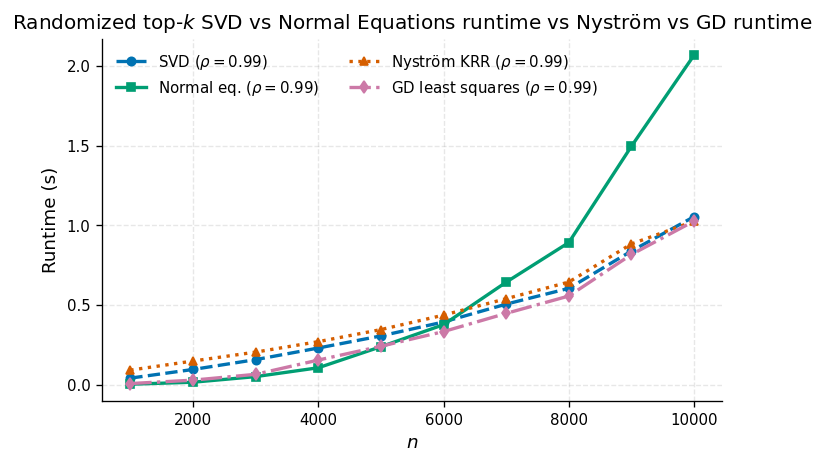

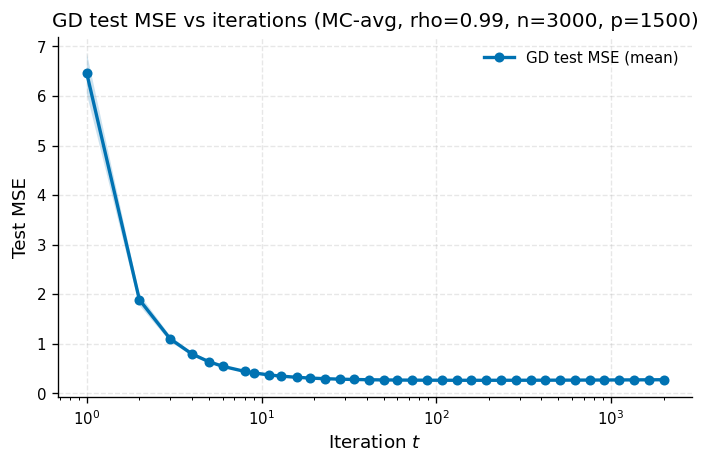

[GD] rho=0.99, n=3000, p=1500: best mean MSE at t*=159: 0.2587


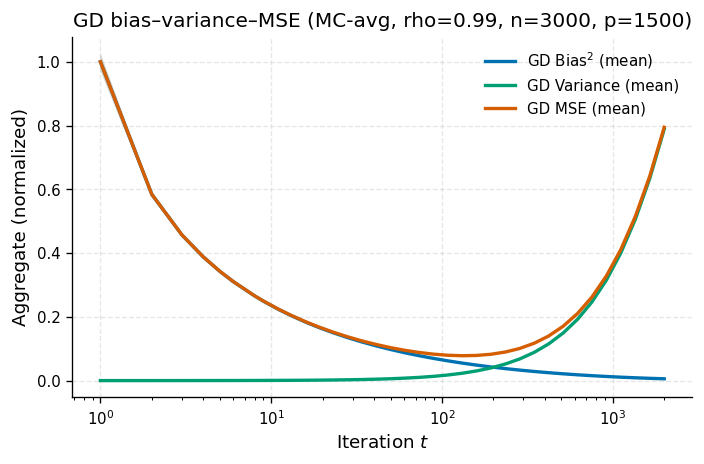

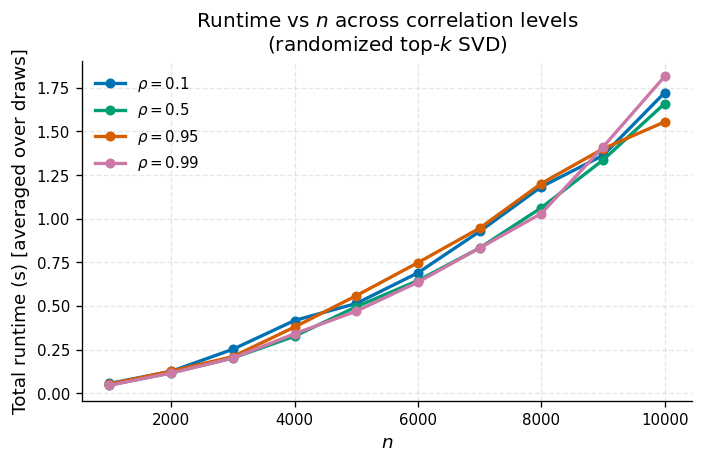

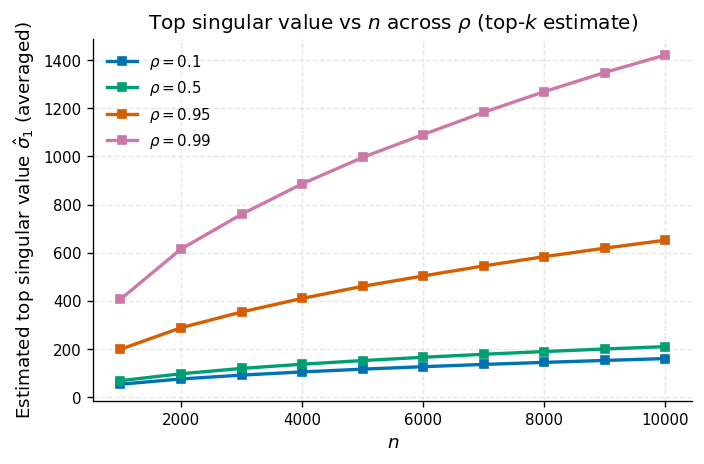

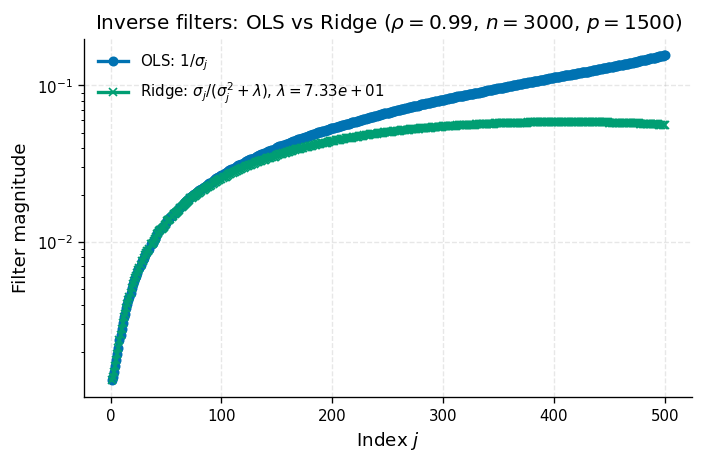

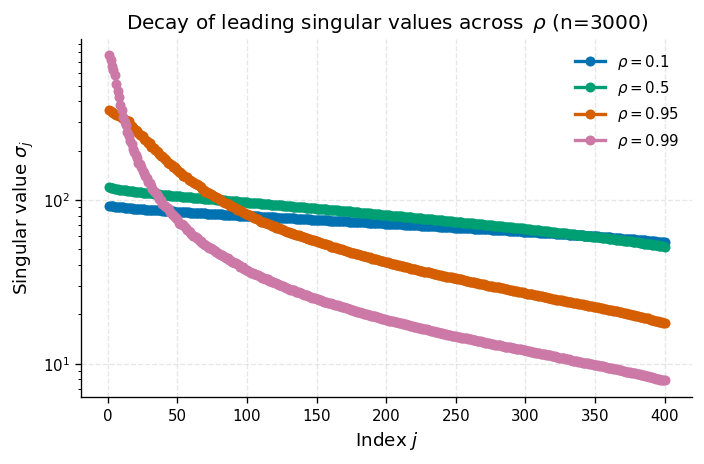

In [288]:
rho_plot = 0.99
n_plot = 3000
p_plot = n_plot // 2

# plot_ridge_mc_combo(ridge_results, rho=rho_plot, n=n_plot, p=p_plot)
plot_svd_vs_ne_runtime_from_df(df_times,rhos=(0.99,))
plot_gd_mc_combo(gd_results, rho=rho_plot, n=n_plot, p=p_plot,show_spectral=True, normalize = True)
plot_runtime_scaling(df_times)
plot_ols_vs_ridge_filters(rho=rho_plot, n=n_plot, p=p_plot, k_top=500, seed=7)
plot_singular_decay_across_rho(svd_spectra=svd_spectra, rhos=(0.10, 0.50, 0.95, 0.99), n=3000, k_max=1500)


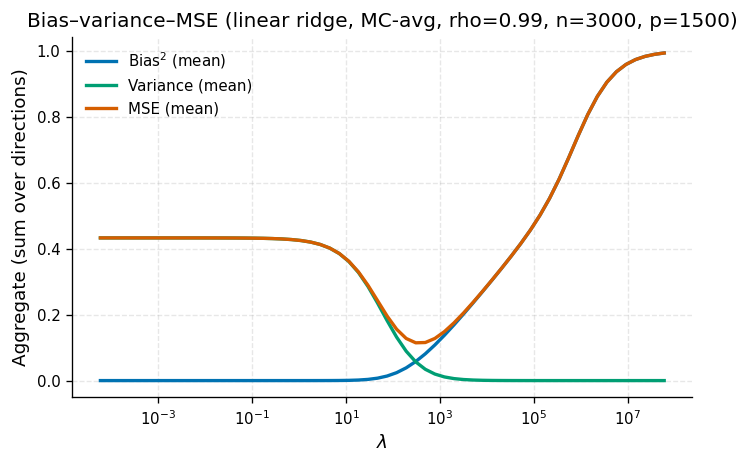

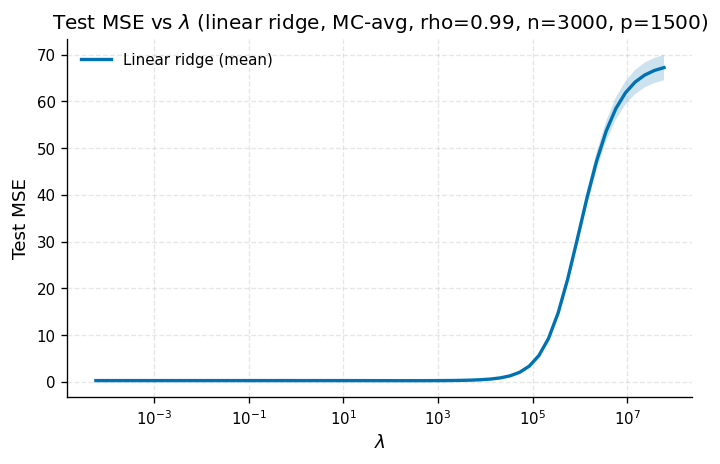

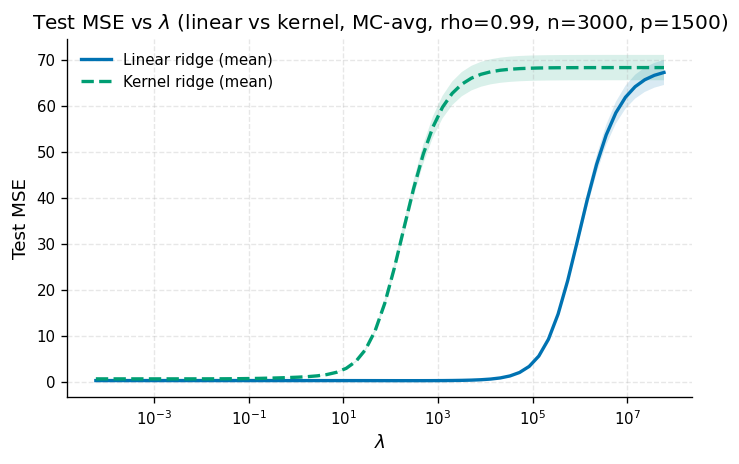

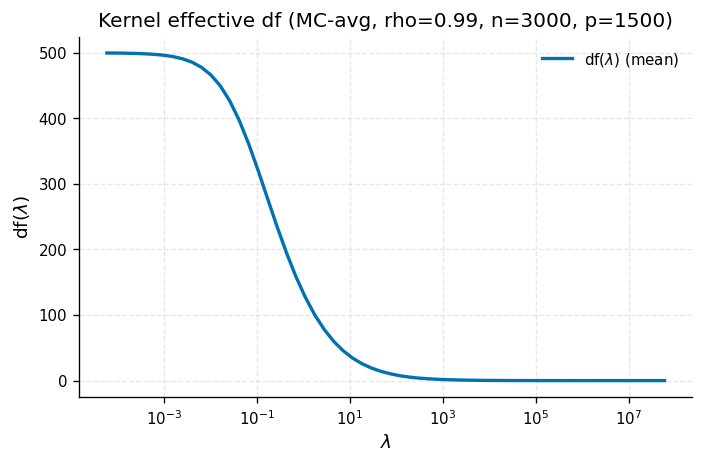

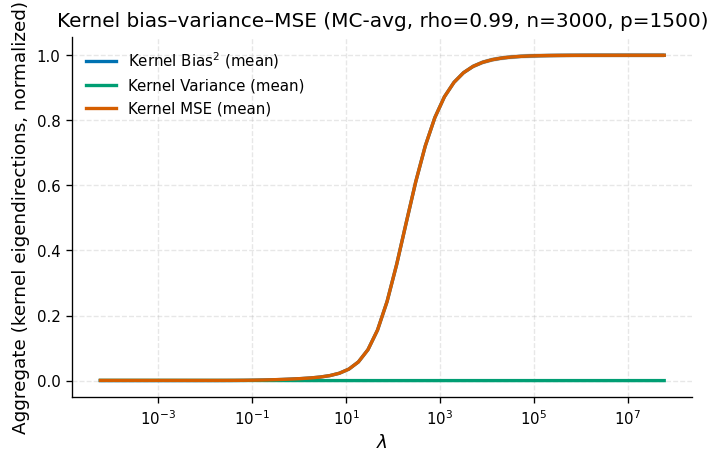

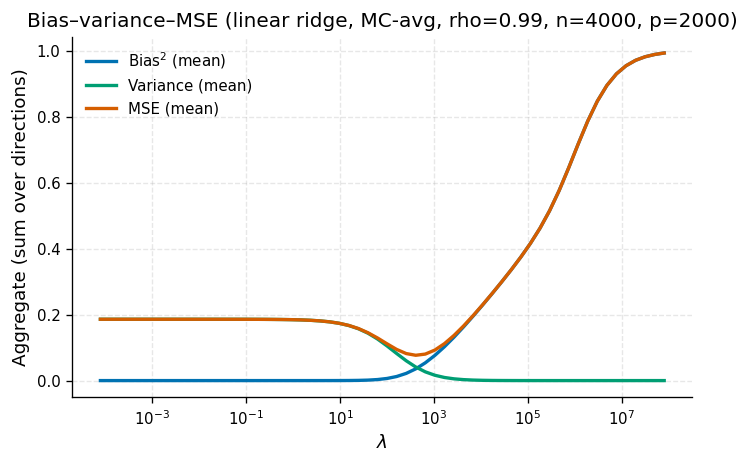

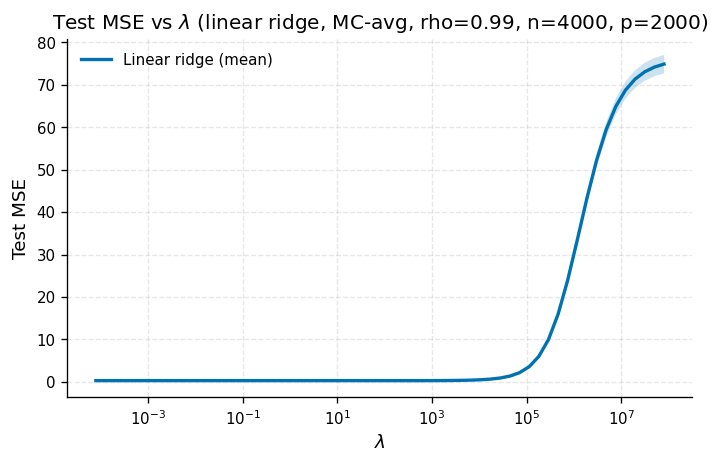

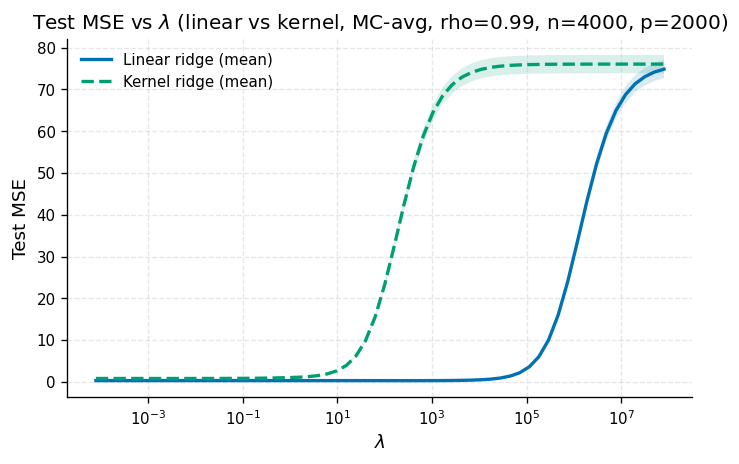

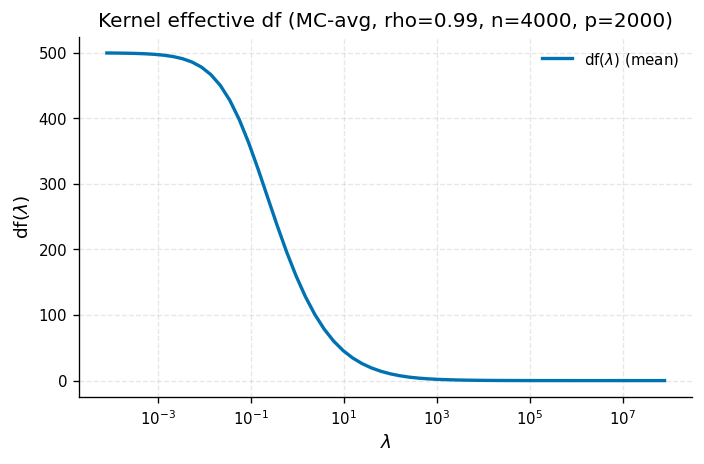

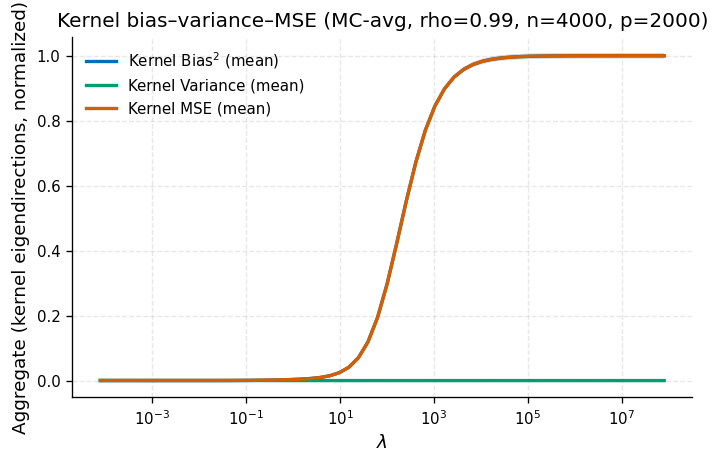

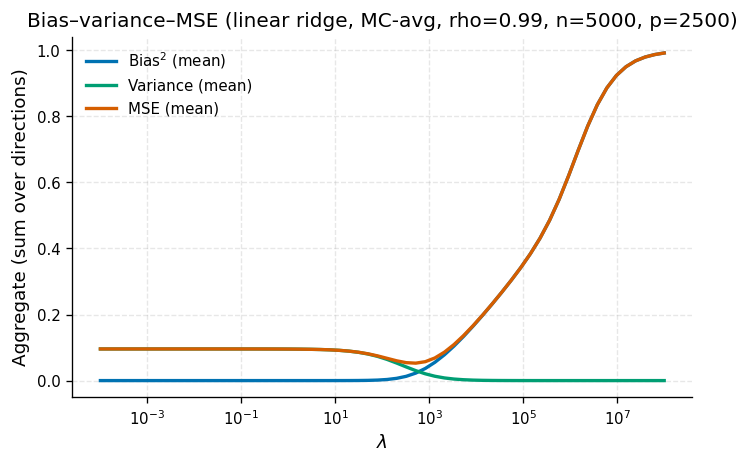

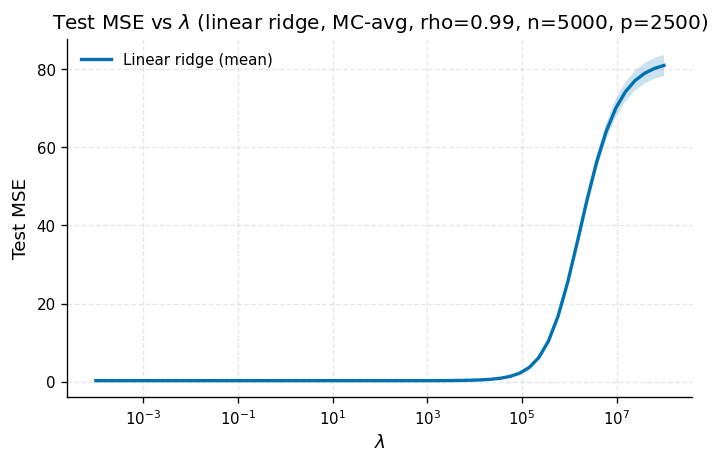

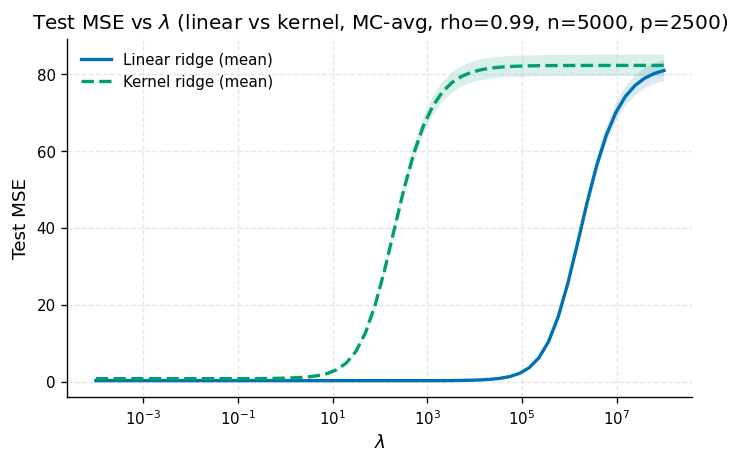

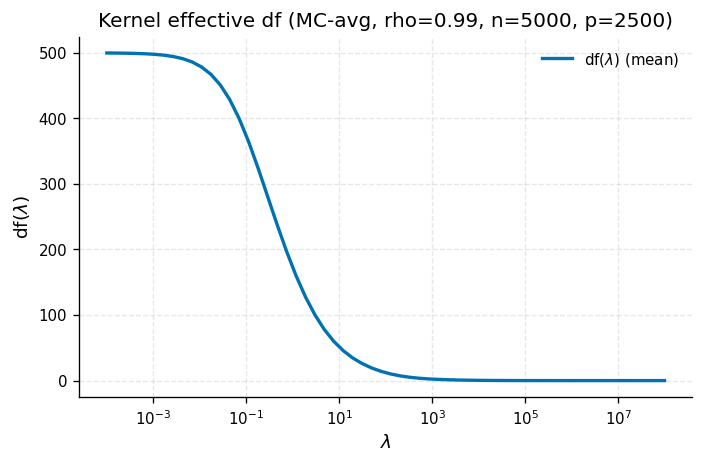

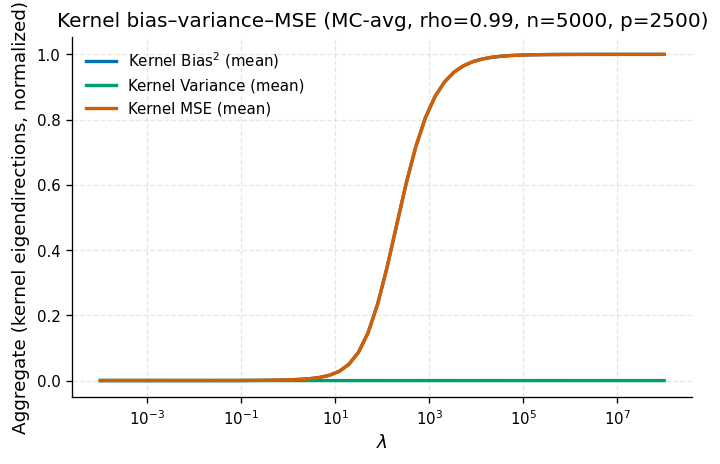

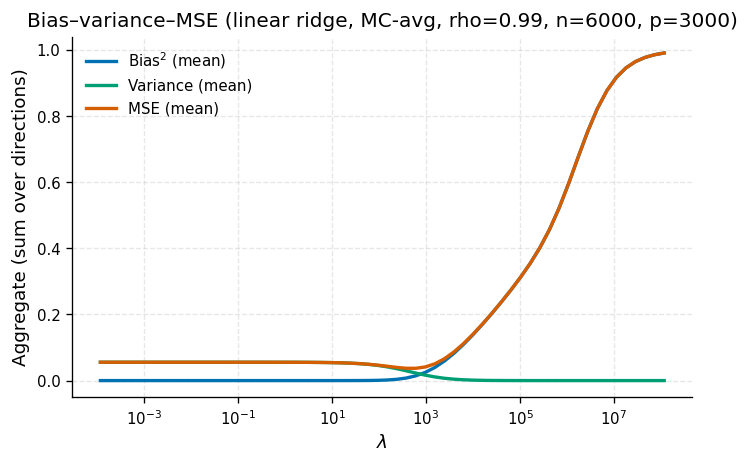

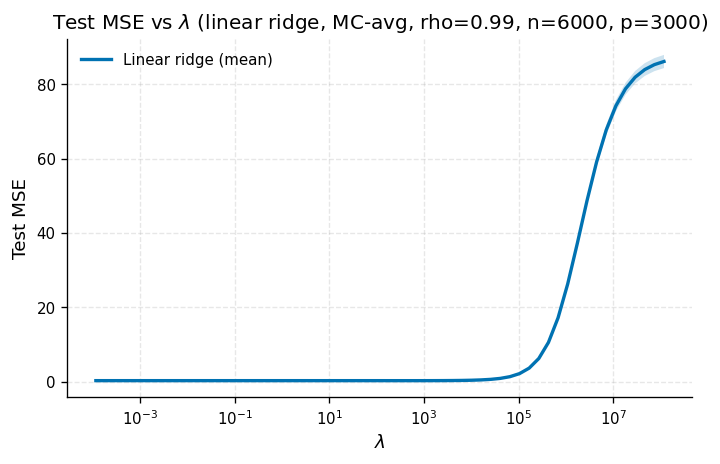

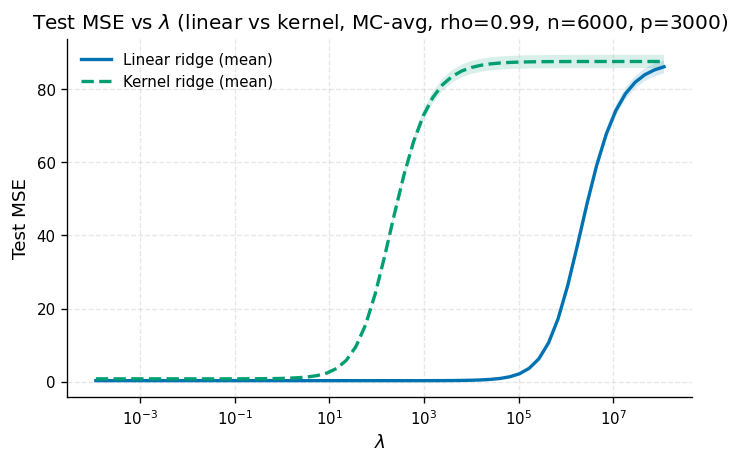

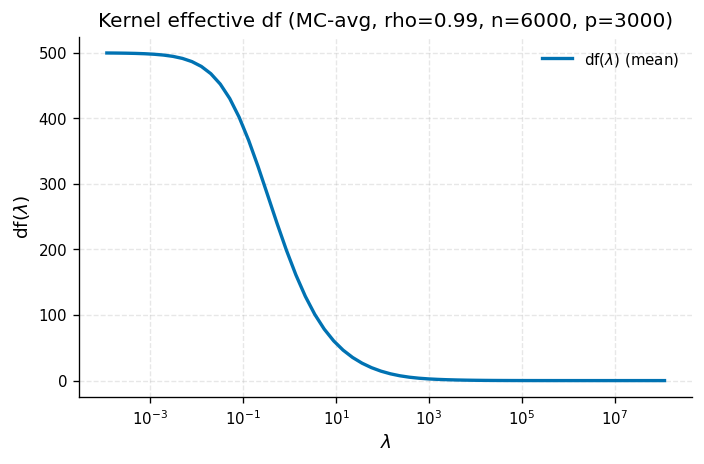

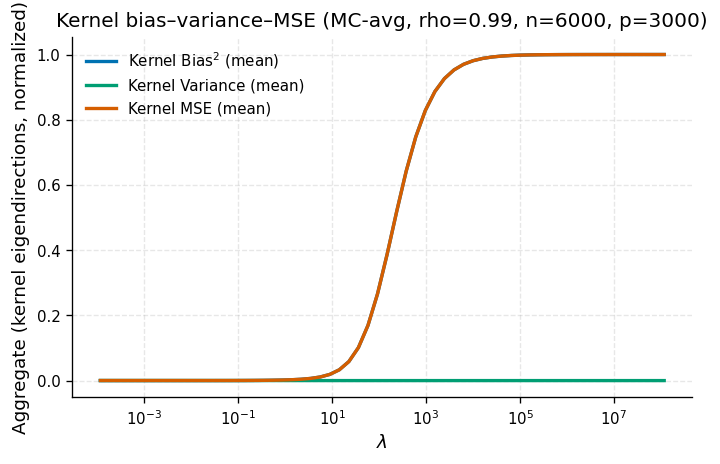

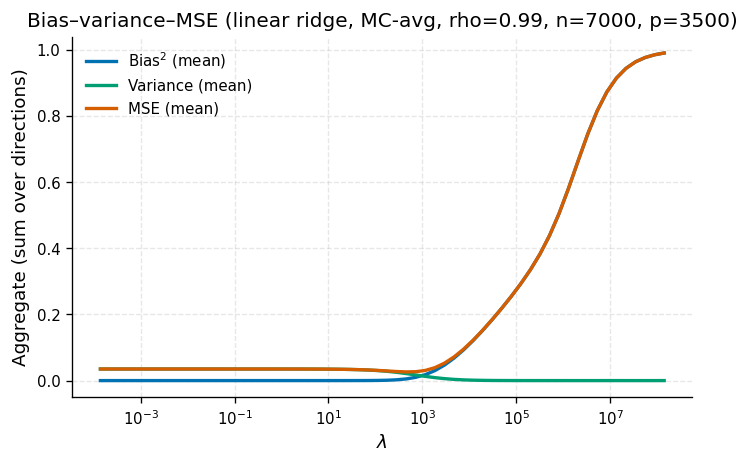

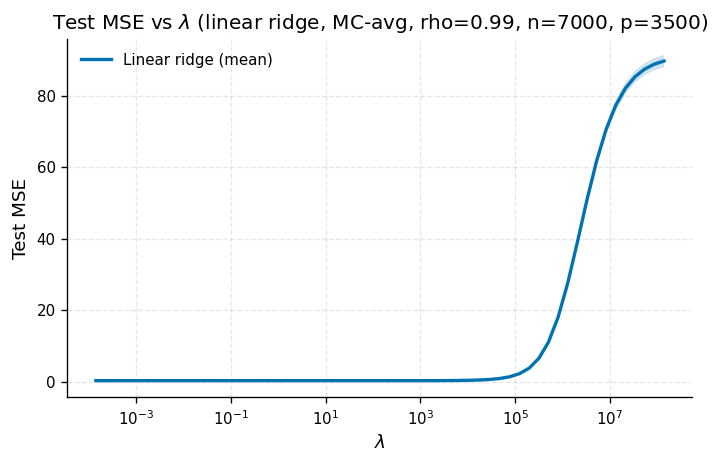

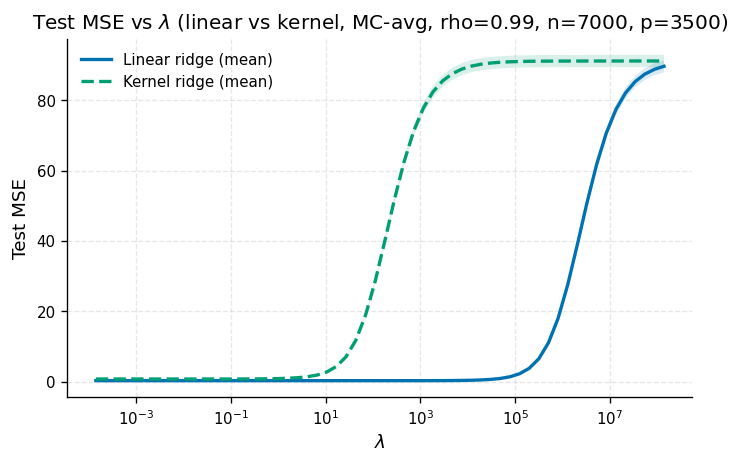

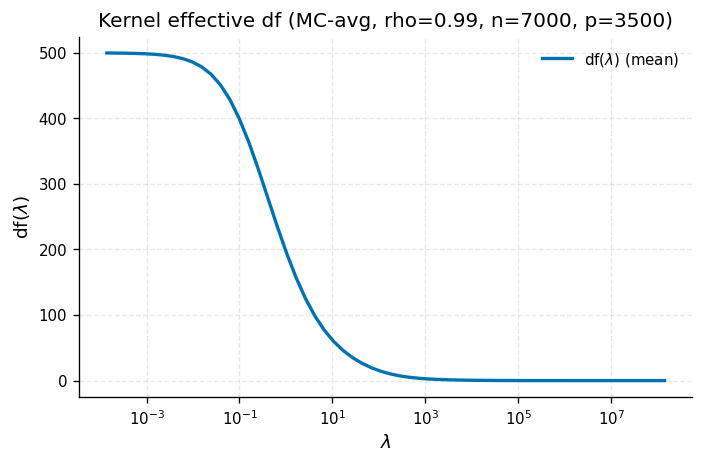

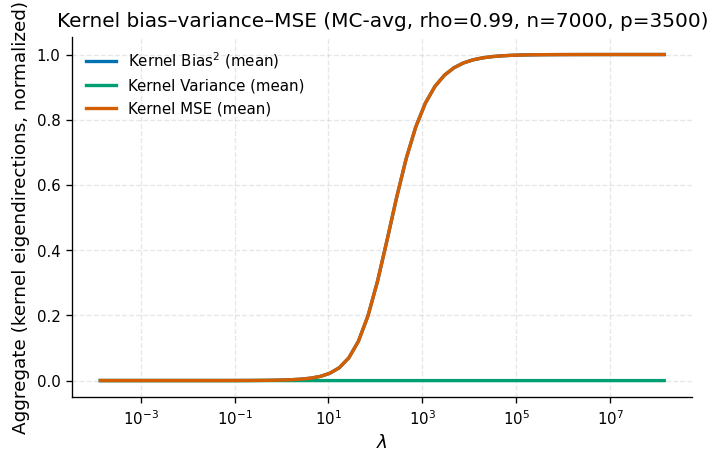

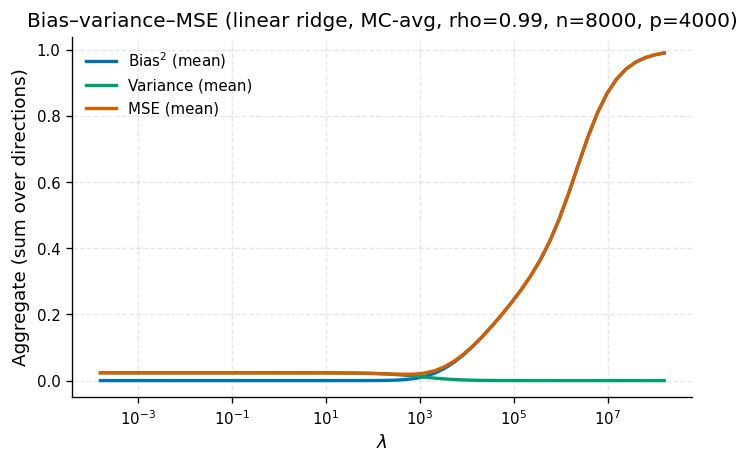

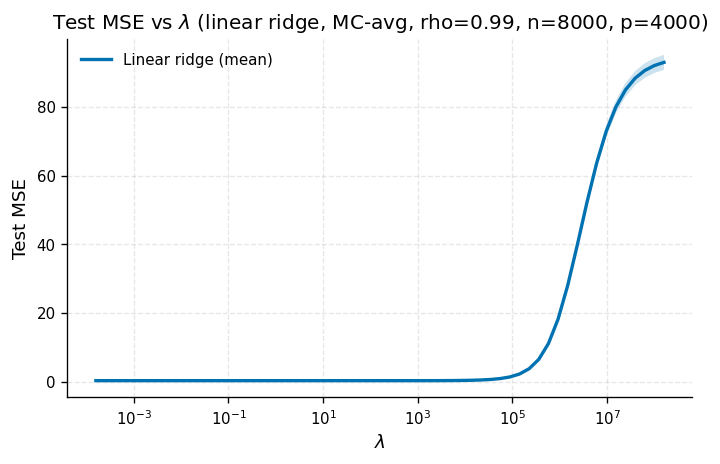

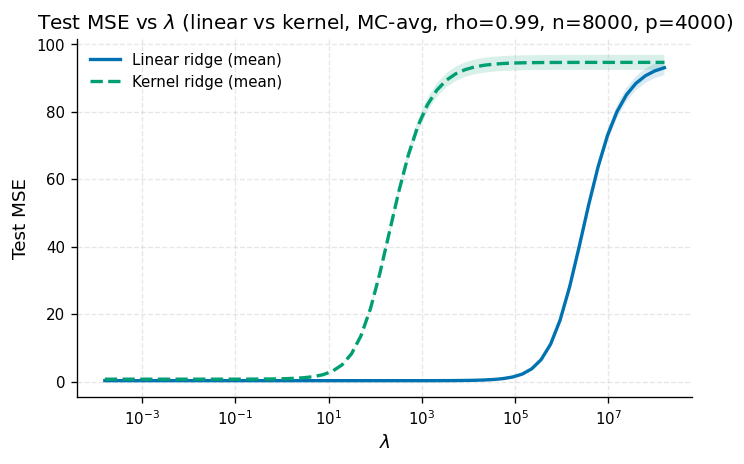

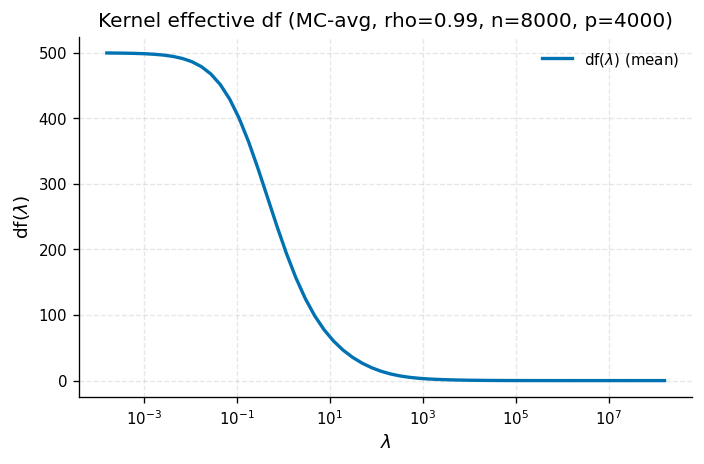

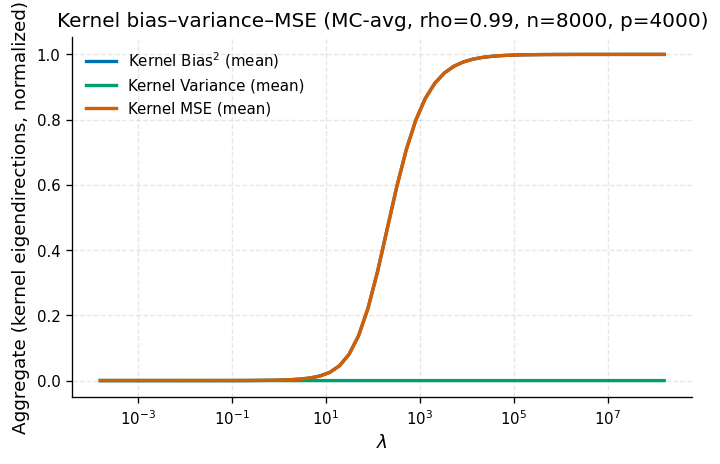

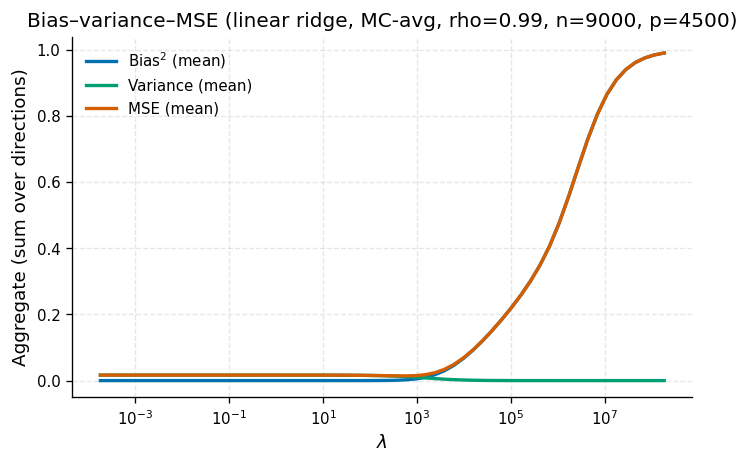

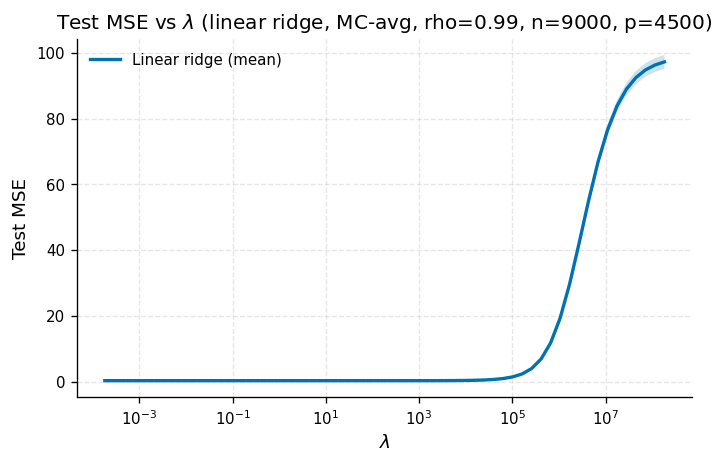

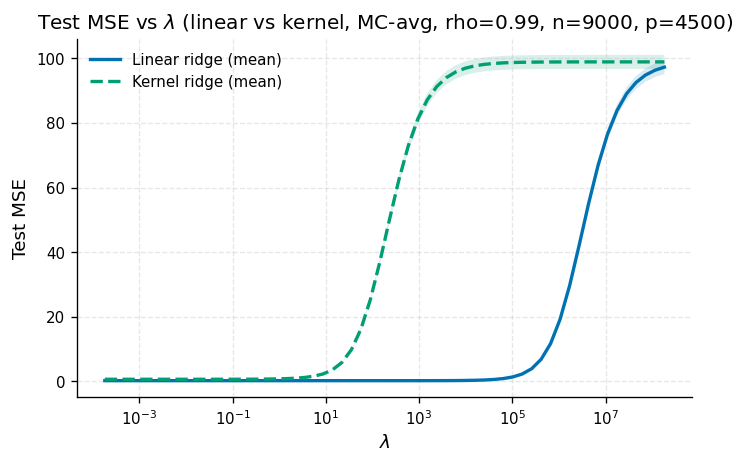

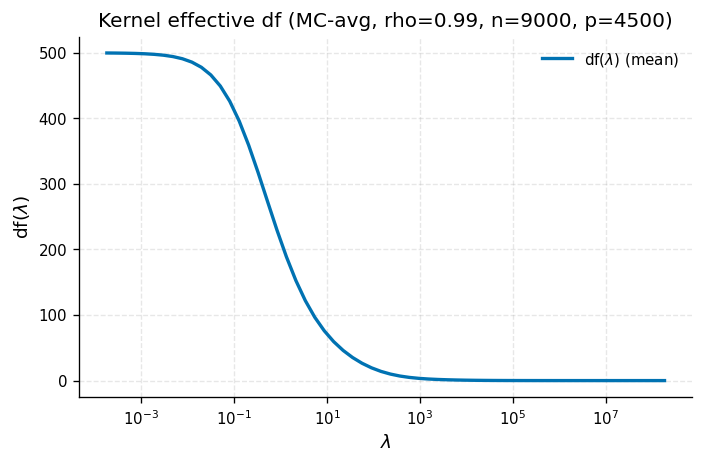

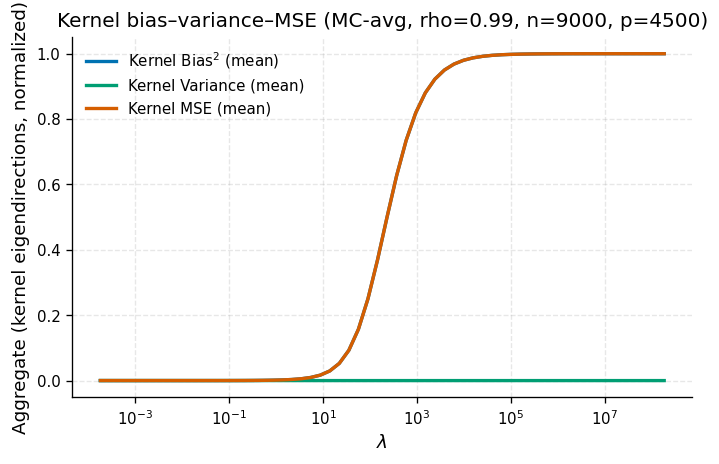

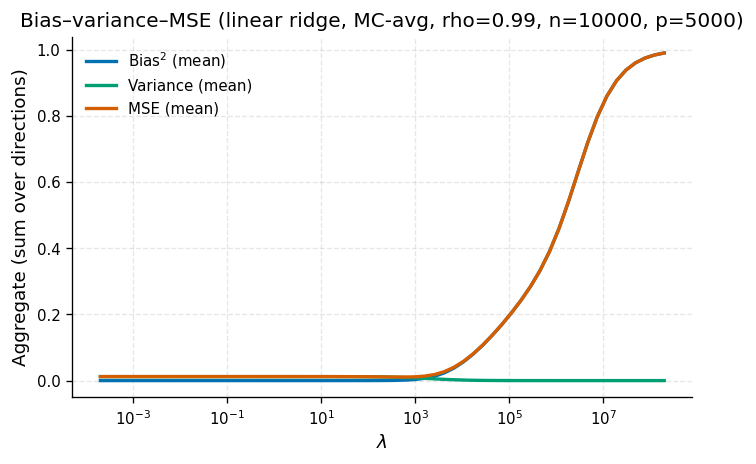

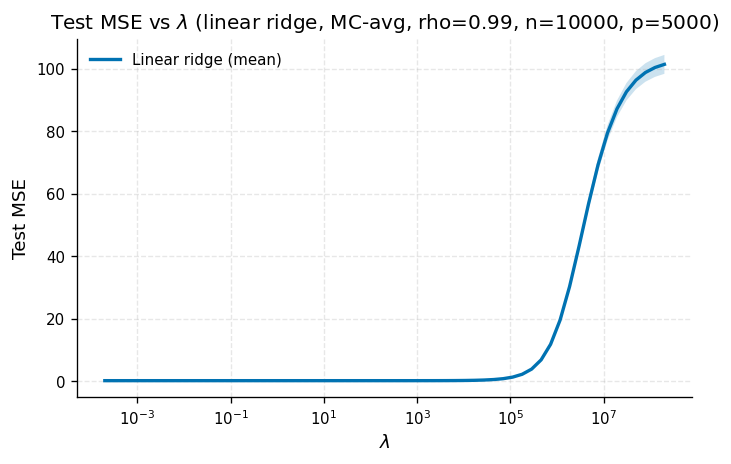

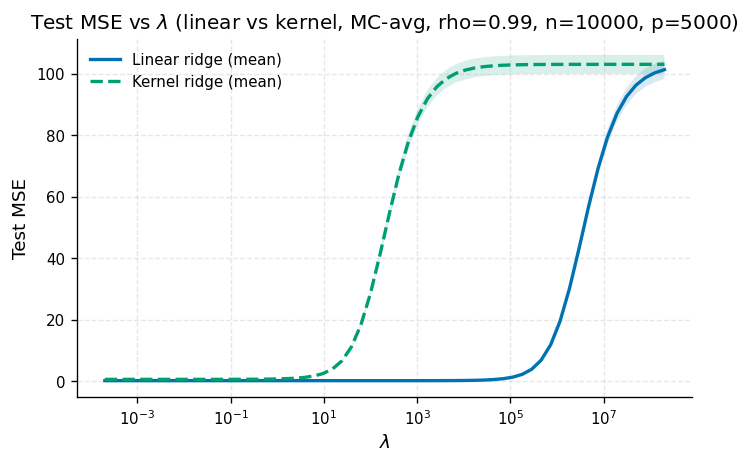

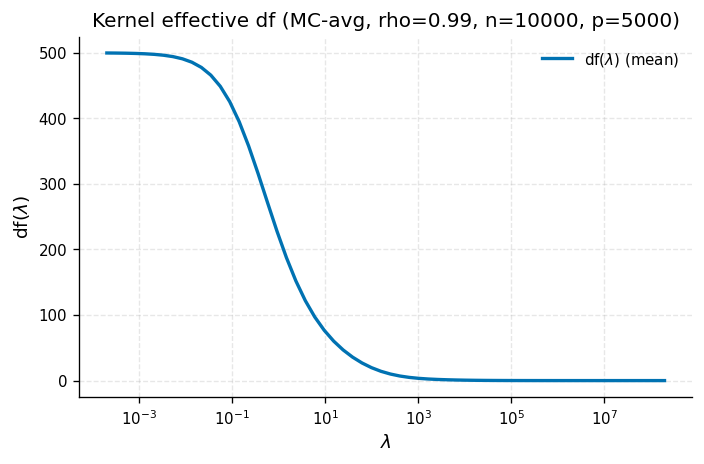

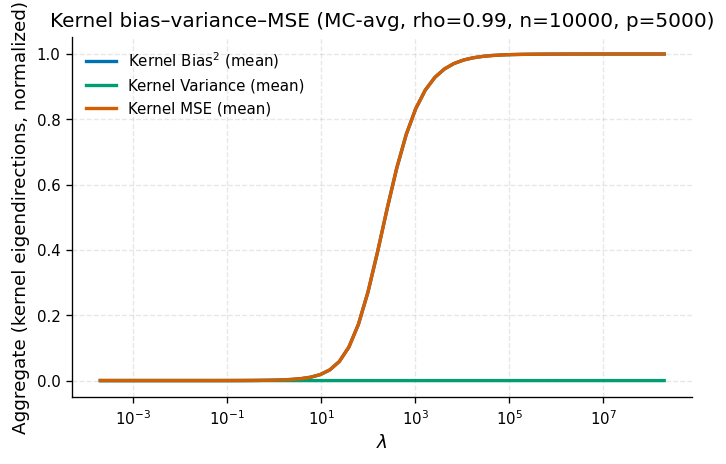

In [289]:
plot_ridge_mc_combo(
    ridge_results,
    rho=0.99,
    n=3000,
    p=1500,
    show_kernel=True,
    show_bands=True,
    normalize_linear=False,   # or True, as you like
    normalize_kernel=True,    # <<< this is the key
)

plot_ridge_mc_combo(
    ridge_results,
    rho=0.99,
    n=4000,
    p=2000,
    show_kernel=True,
    show_bands=True,
    normalize_linear=False,   # or True, as you like
    normalize_kernel=True,    # <<< this is the key
)

plot_ridge_mc_combo(
    ridge_results,
    rho=0.99,
    n=5000,
    p=2500,
    show_kernel=True,
    show_bands=True,
    normalize_linear=False,   # or True, as you like
    normalize_kernel=True,    # <<< this is the key
)

plot_ridge_mc_combo(
    ridge_results,
    rho=0.99,
    n=6000,
    p=3000,
    show_kernel=True,
    show_bands=True,
    normalize_linear=False,   # or True, as you like
    normalize_kernel=True,    # <<< this is the key
)

plot_ridge_mc_combo(
    ridge_results,
    rho=0.99,
    n=7000,
    p=3500,
    show_kernel=True,
    show_bands=True,
    normalize_linear=False,   # or True, as you like
    normalize_kernel=True,    # <<< this is the key
)

plot_ridge_mc_combo(
    ridge_results,
    rho=0.99,
    n=8000,
    p=4000,
    show_kernel=True,
    show_bands=True,
    normalize_linear=False,   # or True, as you like
    normalize_kernel=True,    # <<< this is the key
)

plot_ridge_mc_combo(
    ridge_results,
    rho=0.99,
    n=9000,
    p=4500,
    show_kernel=True,
    show_bands=True,
    normalize_linear=False,   # or True, as you like
    normalize_kernel=True,    # <<< this is the key
)

plot_ridge_mc_combo(
    ridge_results,
    rho=0.99,
    n=10000,
    p=5000,
    show_kernel=True,
    show_bands=True,
    normalize_linear=False,   # or True, as you like
    normalize_kernel=True,    # <<< this is the key
)

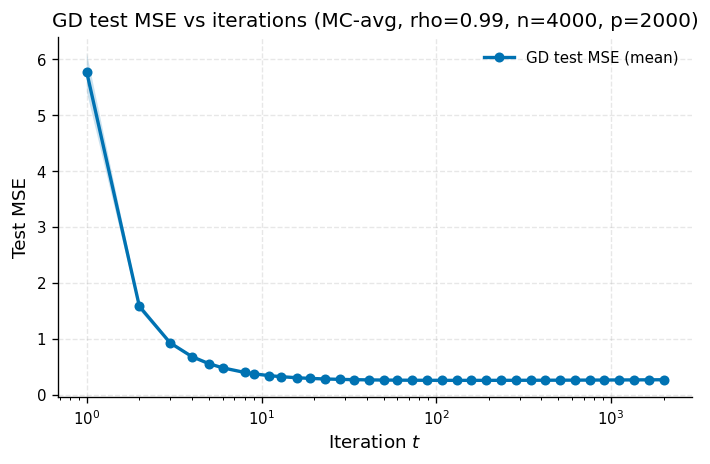

[GD] rho=0.99, n=4000, p=2000: best mean MSE at t*=159: 0.2560


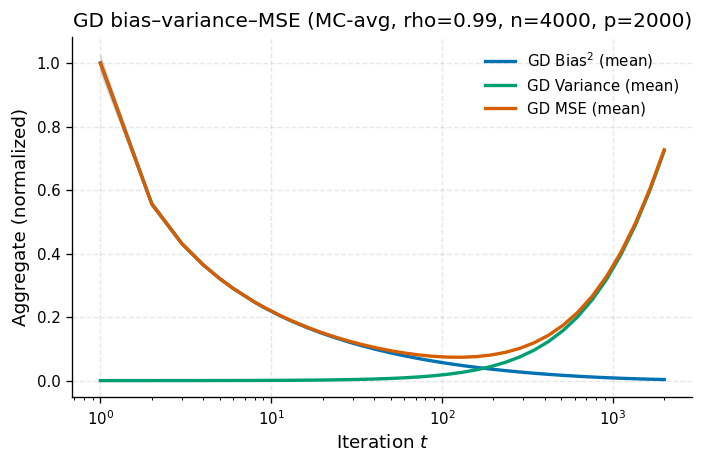

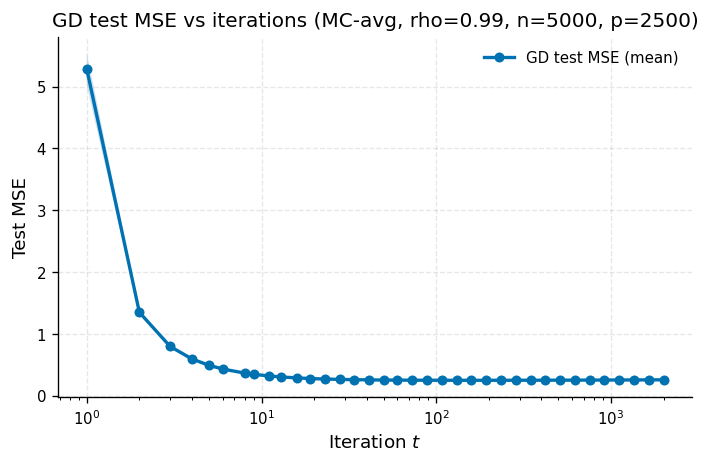

[GD] rho=0.99, n=5000, p=2500: best mean MSE at t*=159: 0.2547


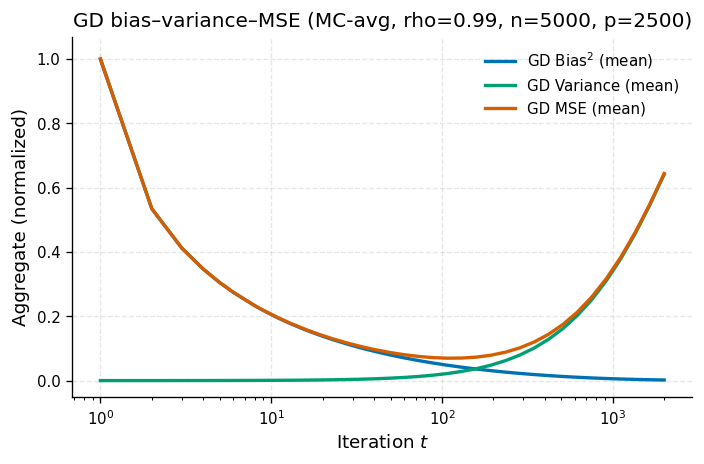

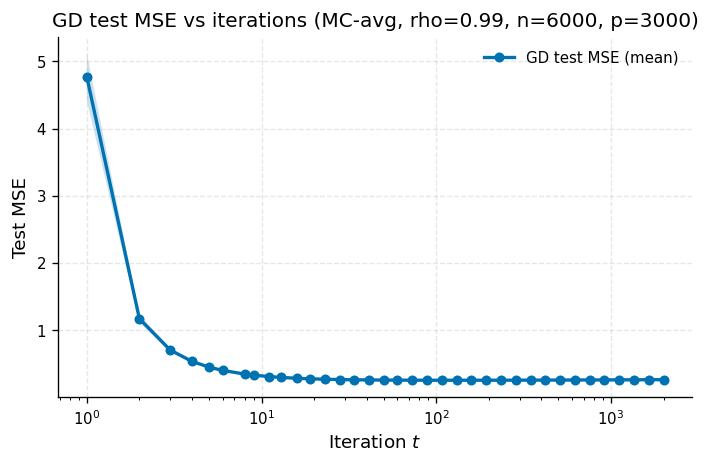

[GD] rho=0.99, n=6000, p=3000: best mean MSE at t*=131: 0.2561


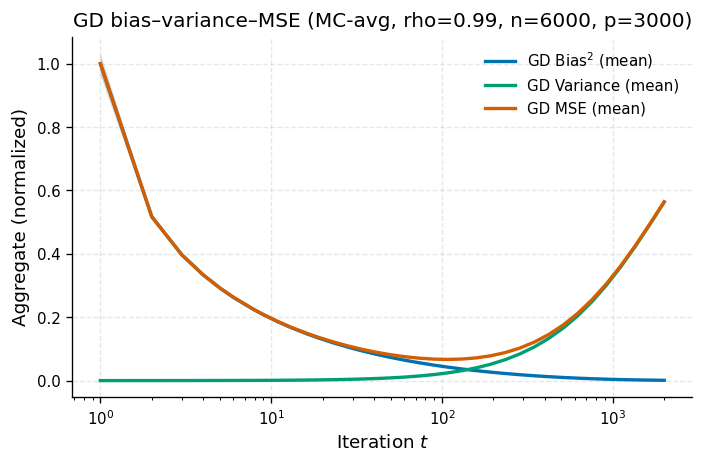

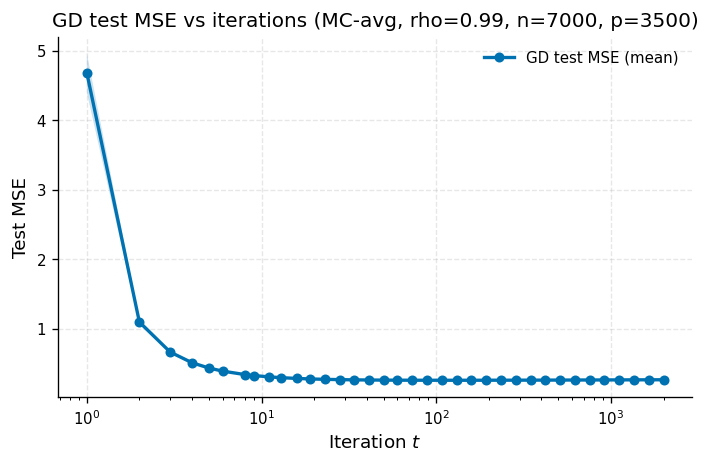

[GD] rho=0.99, n=7000, p=3500: best mean MSE at t*=108: 0.2562


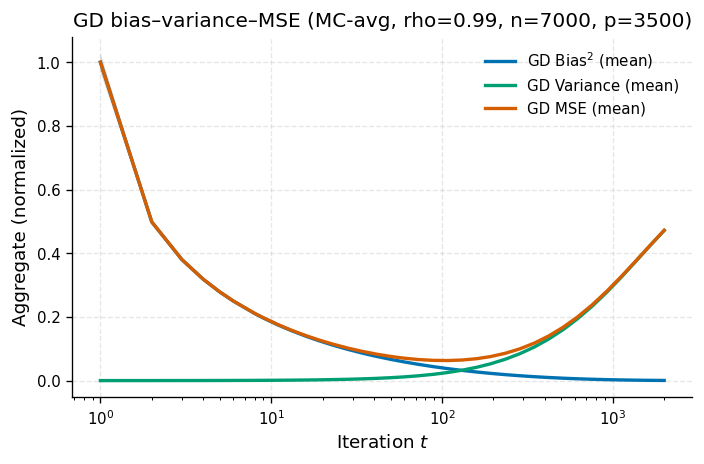

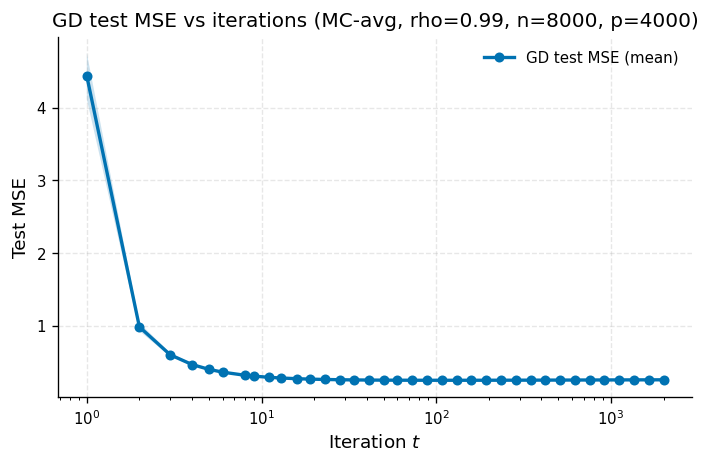

[GD] rho=0.99, n=8000, p=4000: best mean MSE at t*=108: 0.2550


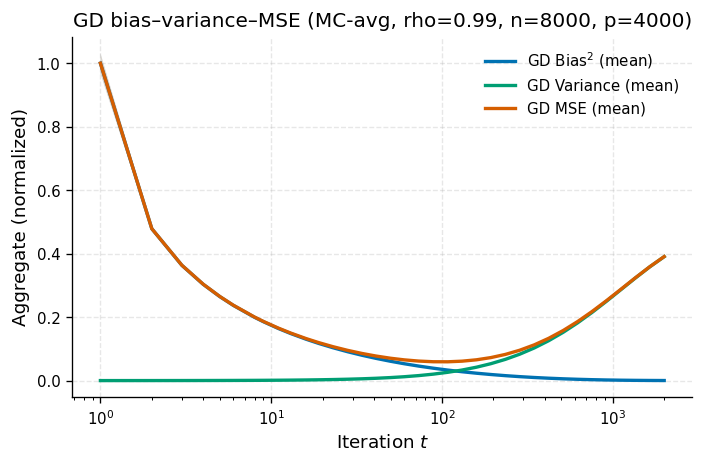

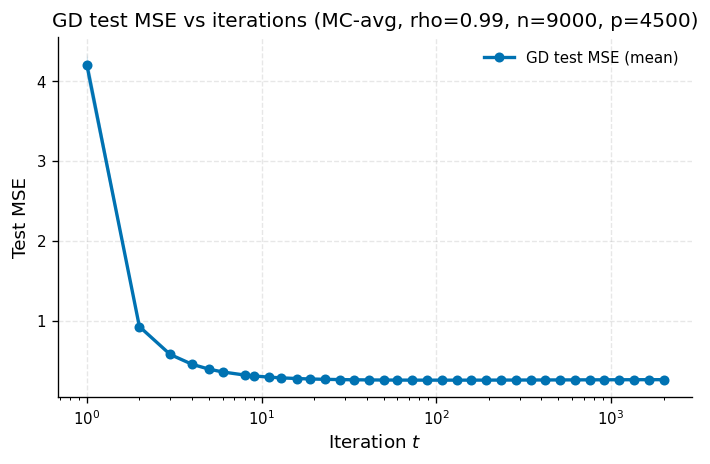

[GD] rho=0.99, n=9000, p=4500: best mean MSE at t*=108: 0.2556


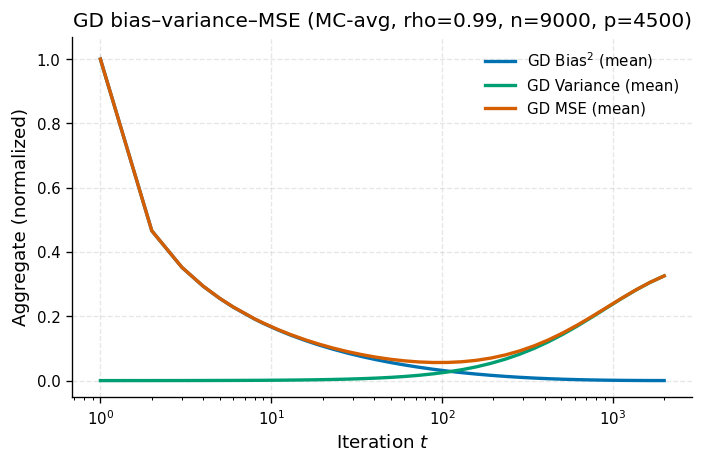

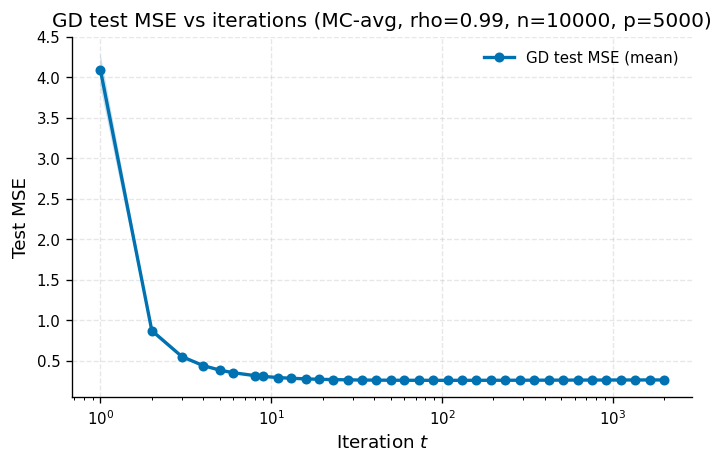

[GD] rho=0.99, n=10000, p=5000: best mean MSE at t*=108: 0.2559


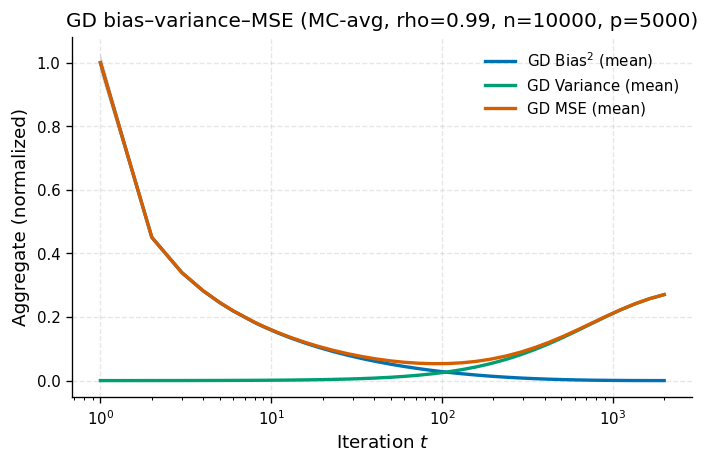

In [290]:
plot_gd_mc_combo(gd_results, rho=rho_plot, n=4000, p=2000,show_spectral=True, normalize = True)
plot_gd_mc_combo(gd_results, rho=rho_plot, n=5000, p=2500,show_spectral=True, normalize = True)
plot_gd_mc_combo(gd_results, rho=rho_plot, n=6000, p=3000,show_spectral=True, normalize = True)
plot_gd_mc_combo(gd_results, rho=rho_plot, n=7000, p=3500,show_spectral=True, normalize = True)
plot_gd_mc_combo(gd_results, rho=rho_plot, n=8000, p=4000,show_spectral=True, normalize = True)
plot_gd_mc_combo(gd_results, rho=rho_plot, n=9000, p=4500,show_spectral=True, normalize = True)
plot_gd_mc_combo(gd_results, rho=rho_plot, n=10000, p=5000,show_spectral=True, normalize = True)


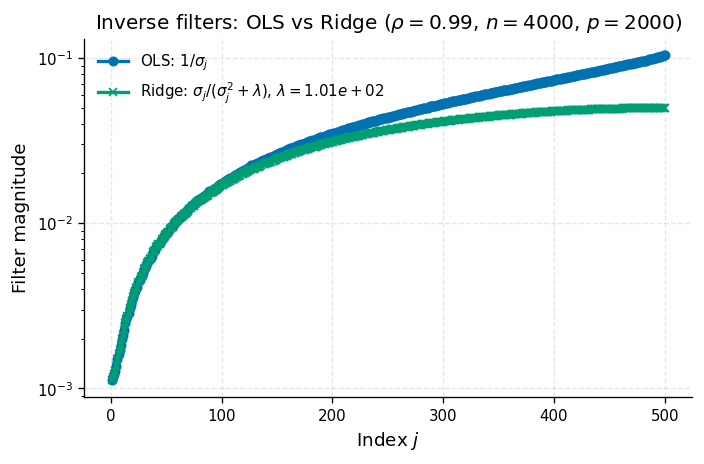

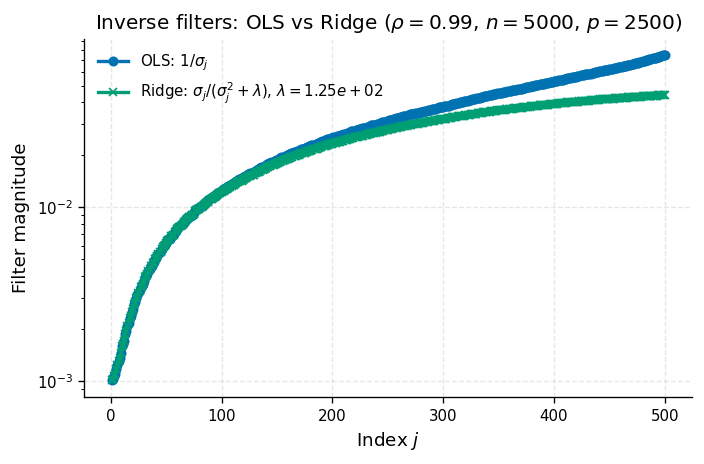

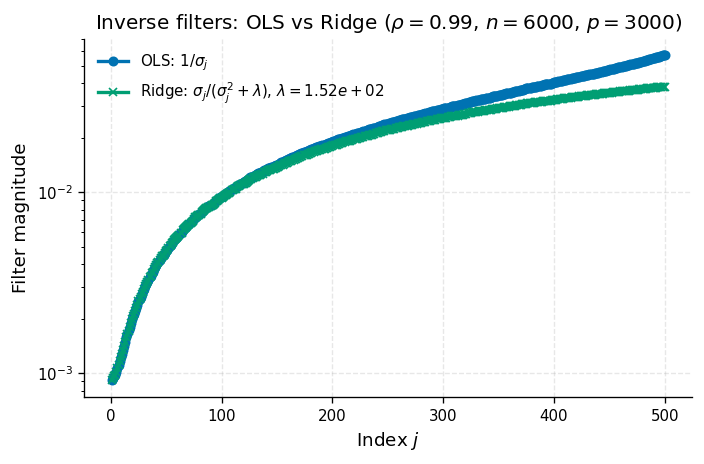

In [292]:
plot_ols_vs_ridge_filters(rho=rho_plot, n=4000, p=2000, k_top=500, seed=7)
plot_ols_vs_ridge_filters(rho=rho_plot, n=5000, p=2500, k_top=500, seed=7)
plot_ols_vs_ridge_filters(rho=rho_plot, n=6000, p=3000, k_top=500, seed=7)


# Data    

In [300]:
%reset -f

In [304]:
import math
import time
from typing import Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



from numpy.random import default_rng
from numpy.linalg import svd
from time import perf_counter

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.utils.extmath import randomized_svd

Full shape: (52397, 280) (52397,)
Subsampled X_base: (5000, 280)
y stats: min 0.0 max 6.736966958001855 mean 0.667646882488338 std 1.1383601993251204
After polynomial expansion: (5000, 1890)


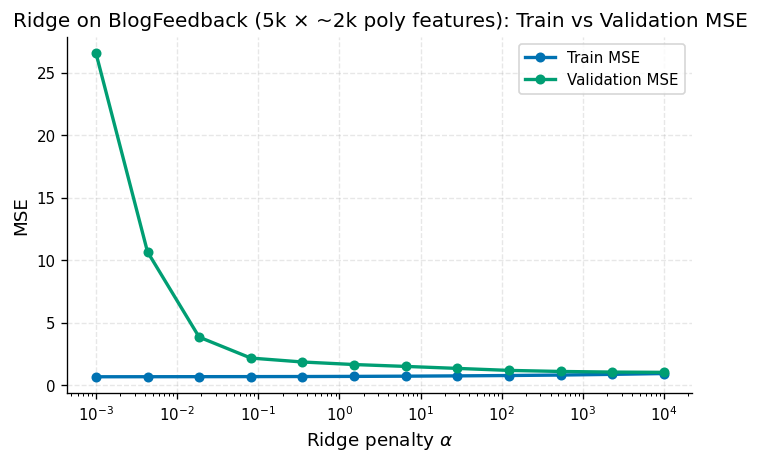

Best alpha (poly ridge): 10000.0


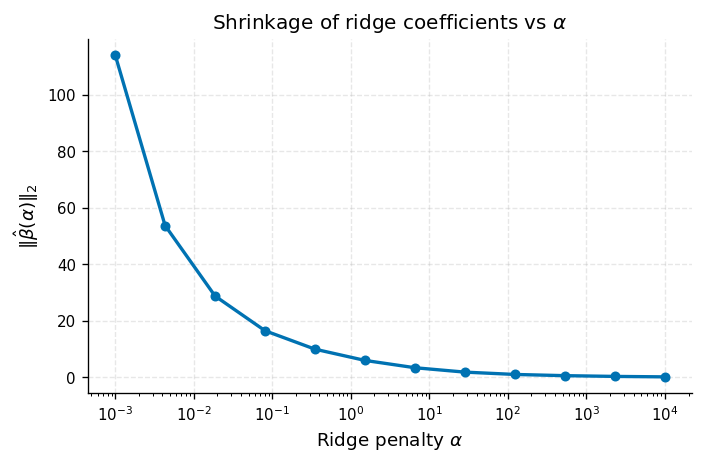

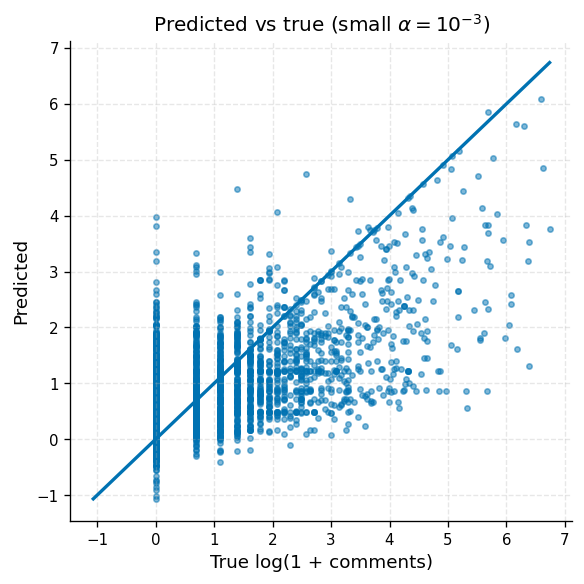

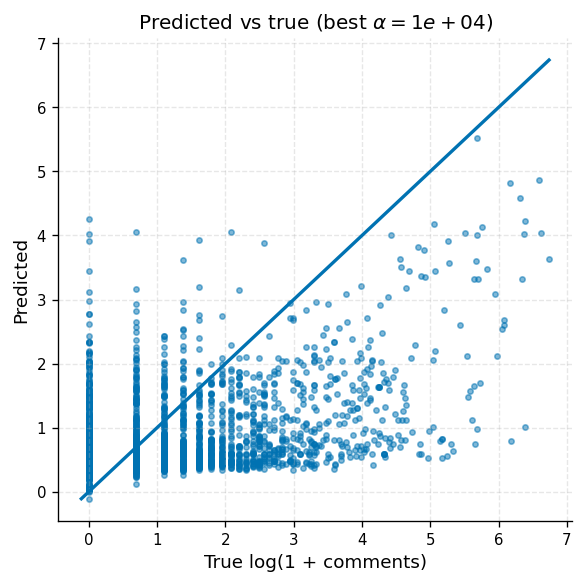

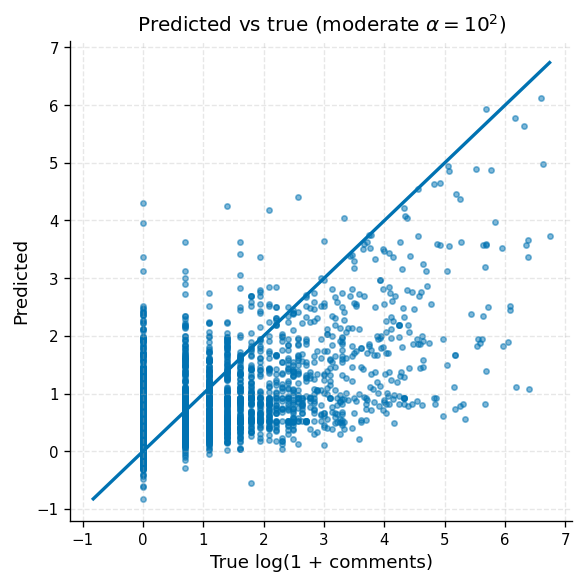

In [305]:

# ----------------------------------------------------------
# Global settings
# ----------------------------------------------------------
K_SVD = 500               # number of singular directions for SVD & GD
NYSTROM_COMPONENTS = 500  # Nyström landmarks / feature dimension

# ==========================================================
# 1. Load BlogFeedback, subsample, build polynomial features
# ==========================================================
df = pd.read_csv("blogData_train.csv", header=None)

X_full = df.iloc[:, :-1].to_numpy(dtype=float)   # 280 features
y_raw  = df.iloc[:, -1].to_numpy(dtype=float)    # comments in next 24h

print("Full shape:", X_full.shape, y_raw.shape)  # ~ (52397, 280)

# Target: log(1 + comments) to reduce skew
y_full = np.log1p(y_raw)

# --- Subsample ~5000 rows ---
rng = default_rng(0)
n_target = 5000
idx_rows = rng.choice(X_full.shape[0], size=n_target, replace=False)

X_base = X_full[idx_rows, :]   # (5000, 280)
y      = y_full[idx_rows]

print("Subsampled X_base:", X_base.shape)
print("y stats: min", y.min(), "max", y.max(), "mean", y.mean(), "std", y.std())

# --- choose 60 base features and build degree-2 poly (~2k features) ---
p0 = 60
idx_feats = rng.choice(X_base.shape[1], size=p0, replace=False)

X_sub = X_base[:, idx_feats]   # (5000, 60)
X_lin = X_sub                  # raw 60-dim subset for Nyström later

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_sub)
print("After polynomial expansion:", X_poly.shape)  # ~ (5000, ~1890)

X = X_poly

# ==========================================================
# 2. Ridge on polynomial features: CV, coef norms, diagnostics
# ==========================================================
alphas = np.logspace(-3, 4, 12)  # 1e-3 ... 1e4
kf = KFold(n_splits=5, shuffle=True, random_state=0)

mean_train_mse_poly, mean_val_mse_poly = [], []

for alpha in alphas:
    train_mse, val_mse = [], []
    for tr_idx, val_idx in kf.split(X):
        X_tr, X_val = X[tr_idx], X[val_idx]
        y_tr, y_val = y[tr_idx], y[val_idx]

        model = make_pipeline(
            StandardScaler(with_mean=True, with_std=True),
            Ridge(alpha=alpha, fit_intercept=True)
        )
        model.fit(X_tr, y_tr)

        y_tr_pred = model.predict(X_tr)
        y_val_pred = model.predict(X_val)

        train_mse.append(np.mean((y_tr_pred - y_tr)**2))
        val_mse.append(np.mean((y_val_pred - y_val)**2))

    mean_train_mse_poly.append(np.mean(train_mse))
    mean_val_mse_poly.append(np.mean(val_mse))

plt.figure(figsize=(6, 4))
plt.semilogx(alphas, mean_train_mse_poly, marker="o", label="Train MSE")
plt.semilogx(alphas, mean_val_mse_poly, marker="o", label="Validation MSE")
plt.xlabel(r"Ridge penalty $\alpha$")
plt.ylabel("MSE")
plt.title("Ridge on BlogFeedback (5k × ~2k poly features): Train vs Validation MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

best_alpha_poly = alphas[int(np.argmin(mean_val_mse_poly))]
print("Best alpha (poly ridge):", best_alpha_poly)

# --- coef norm vs alpha (fit on full data) ---
coef_norms = []
for alpha in alphas:
    model = make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        Ridge(alpha=alpha, fit_intercept=True)
    )
    model.fit(X, y)
    beta = model.named_steps["ridge"].coef_.ravel()
    coef_norms.append(np.linalg.norm(beta, 2))

plt.figure(figsize=(6, 4))
plt.semilogx(alphas, coef_norms, marker="o")
plt.xlabel(r"Ridge penalty $\alpha$")
plt.ylabel(r"$\|\hat\beta(\alpha)\|_2$")
plt.title("Shrinkage of ridge coefficients vs $\\alpha$")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Predicted vs true for small / mid (best) / large alpha ---
alphas_to_show = [1e-3, best_alpha_poly, 1e2]
labels = [r"small $\alpha=10^{-3}$",
          rf"best $\alpha={best_alpha_poly:.2g}$",
          r"moderate $\alpha=10^{2}$"]

for alpha, lbl in zip(alphas_to_show, labels):
    model = make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        Ridge(alpha=alpha, fit_intercept=True)
    )
    model.fit(X, y)
    y_hat = model.predict(X)

    plt.figure(figsize=(5, 5))
    plt.scatter(y, y_hat, s=10, alpha=0.5)
    lo = min(y.min(), y_hat.min())
    hi = max(y.max(), y_hat.max())
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("True log(1 + comments)")
    plt.ylabel("Predicted")
    plt.title(f"Predicted vs true ({lbl})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


OLS: a = 0.454, b = 0.365
Ridge $\alpha=10^{-1}$: a = 0.430, b = 0.380
Ridge $\alpha=10$: a = 0.395, b = 0.404
Ridge $\alpha=10^{2}$: a = 0.361, b = 0.427
Ridge best $\alpha=1e+04$: a = 0.237, b = 0.510


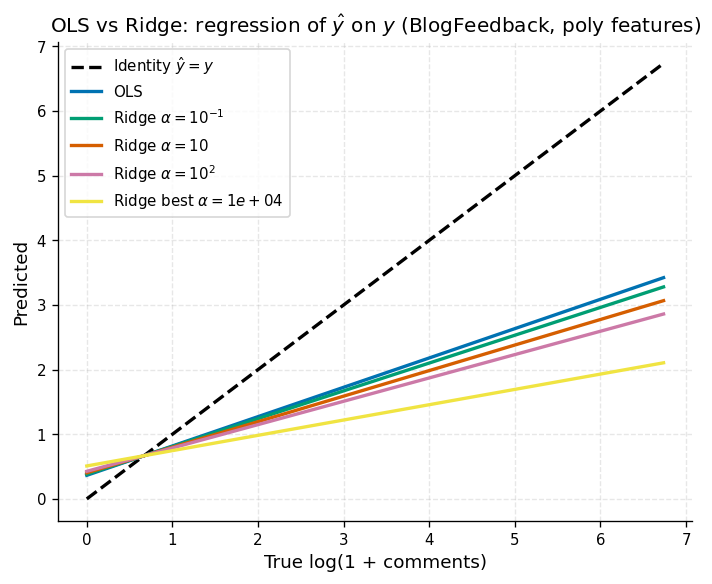

[Global SVD] X_std_global shape: n=5000, p=1890
[Global SVD] truncated rank k = 500
First 5 singular values (trunc): [2070.71981834  787.05803419  397.97987387  359.62939016  306.17037864]


In [306]:
# ==========================================================
# 3. OLS vs Ridge lines: regression of y_hat on y
# ==========================================================
models = {
    "OLS": make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        LinearRegression()
    ),
    r"Ridge $\alpha=10^{-1}$": make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        Ridge(alpha=1e-1, fit_intercept=True)
    ),
    r"Ridge $\alpha=10$": make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        Ridge(alpha=10.0, fit_intercept=True)
    ),
    r"Ridge $\alpha=10^{2}$": make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        Ridge(alpha=1e2, fit_intercept=True)
    ),
    rf"Ridge best $\alpha={best_alpha_poly:.2g}$": make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        Ridge(alpha=best_alpha_poly, fit_intercept=True)
    )
}

line_params = {}   # name -> (a, b)

for name, model in models.items():
    model.fit(X, y)
    y_hat = model.predict(X)
    a, b = np.polyfit(y, y_hat, 1)   # y_hat ≈ a*y + b
    line_params[name] = (a, b)
    print(f"{name}: a = {a:.3f}, b = {b:.3f}")

y_grid = np.linspace(y.min(), y.max(), 200)

plt.figure(figsize=(6, 5))
plt.plot(y_grid, y_grid, "k--", label="Identity $\\hat y = y$")
for name, (a, b) in line_params.items():
    plt.plot(y_grid, a * y_grid + b, label=name)

plt.xlabel("True log(1 + comments)")
plt.ylabel("Predicted")
plt.title("OLS vs Ridge: regression of $\\hat y$ on $y$ (BlogFeedback, poly features)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ==========================================================
# 4. Global standardized design + truncated SVD (k=500)
# ==========================================================
scaler_X_global = StandardScaler(with_mean=True, with_std=True)
X_std_global = scaler_X_global.fit_transform(X_poly)

y_mean_global = y.mean()
y_c_global    = y - y_mean_global

n_svd, p_svd = X_std_global.shape
print(f"[Global SVD] X_std_global shape: n={n_svd}, p={p_svd}")

k_eff = min(K_SVD, p_svd)
U_k, s_k, Vt_k = randomized_svd(
    X_std_global,
    n_components=k_eff,
    random_state=0
)
V_k = Vt_k.T                    # (p × k)
Z_k = U_k * s_k                 # (n × k) features in singular space

print(f"[Global SVD] truncated rank k = {k_eff}")
print("First 5 singular values (trunc):", s_k[:5])

XtX_b = X_std_global.T @ X_std_global
Xty_b = X_std_global.T @ y_c_global


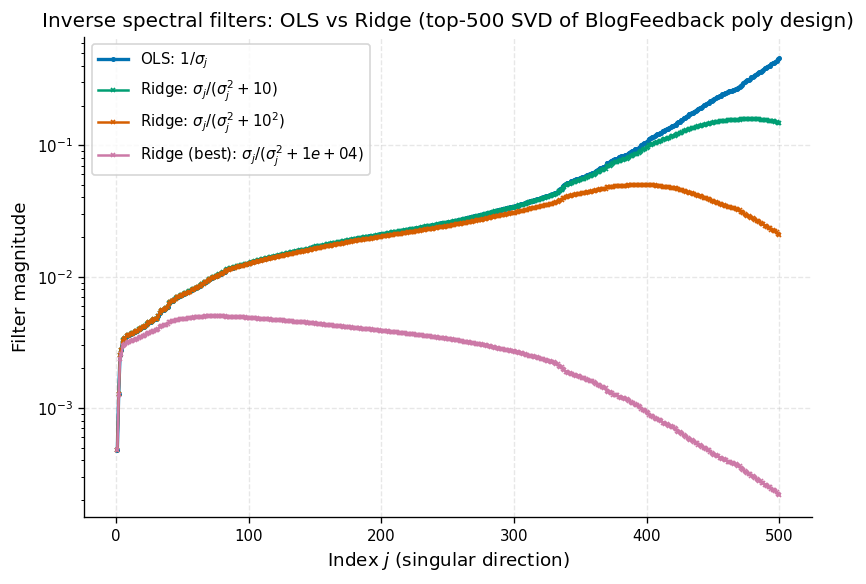

Nyström feature shape: (5000, 500)


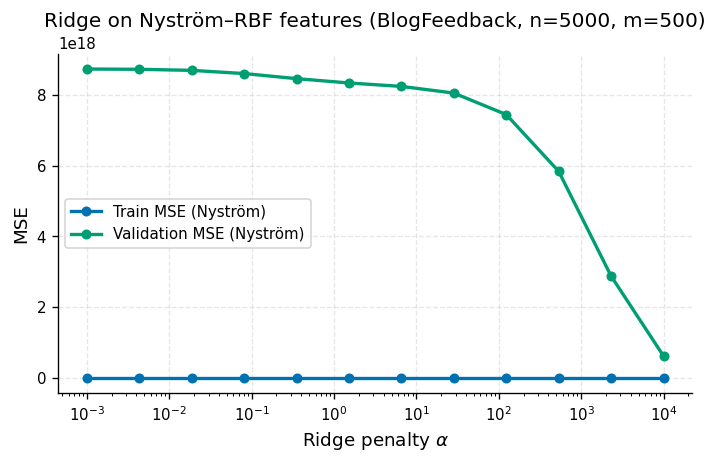

Best alpha (Nyström+RBF): 10000.0


In [307]:
# ==========================================================
# 5. Inverse spectral filters: OLS vs Ridge using s_k (top-500)
# ==========================================================
s_vals = s_k                    # top-k singular values

f_ols = 1.0 / s_vals

def ridge_filter(sigmas, lam):
    return sigmas / (sigmas**2 + lam)

alpha_small = 1e-1
alpha_med   = 10.0
alpha_large = 1e2

f_small = ridge_filter(s_vals, alpha_small)
f_med   = ridge_filter(s_vals, alpha_med)
f_large = ridge_filter(s_vals, alpha_large)
f_best  = ridge_filter(s_vals, best_alpha_poly)

k_plot = len(s_vals)
idx = np.arange(1, k_plot + 1)

plt.figure(figsize=(7, 5))
plt.semilogy(idx, f_ols[:k_plot], marker="o", linewidth=2, markersize=2,
             label="OLS: $1/\\sigma_j$")
plt.semilogy(idx, f_med[:k_plot], marker="x", linewidth=1.5, markersize=2,
             label=r"Ridge: $\sigma_j/(\sigma_j^2 + 10)$")
plt.semilogy(idx, f_large[:k_plot], marker="x", linewidth=1.5, markersize=2,
             label=r"Ridge: $\sigma_j/(\sigma_j^2 + 10^{2})$")
plt.semilogy(idx, f_best[:k_plot], marker="x", linewidth=1.5, markersize=2,
             label=rf"Ridge (best): $\sigma_j/(\sigma_j^2 + {best_alpha_poly:.2g})$")

plt.xlabel("Index $j$ (singular direction)")
plt.ylabel("Filter magnitude")
plt.title("Inverse spectral filters: OLS vs Ridge (top-500 SVD of BlogFeedback poly design)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ==========================================================
# 6. Nyström–RBF features + Ridge CV (m = 500)
# ==========================================================
class NystromRBF(BaseEstimator, TransformerMixin):
    """
    Nyström approximation to Gaussian RBF kernel:
        k(x, z) = exp(-gamma * ||x - z||^2)
    Produces Z = K_nm W^{-1/2}, with m = n_components landmarks.
    """
    def __init__(self, n_components=NYSTROM_COMPONENTS, gamma=None, random_state=None):
        self.n_components = n_components
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None):
        X = np.asarray(X)
        n_samples = X.shape[0]

        # Standardize input features
        self.scaler_ = StandardScaler(with_mean=True, with_std=True)
        X_scaled = self.scaler_.fit_transform(X)

        # Choose landmark indices
        rng = np.random.default_rng(self.random_state)
        m = min(self.n_components, n_samples)
        self.landmark_indices_ = rng.choice(n_samples, size=m, replace=False)
        self.X_land_ = X_scaled[self.landmark_indices_]

        # Set gamma (median heuristic if None)
        if self.gamma is None:
            idx_sample = rng.choice(n_samples, size=min(500, n_samples), replace=False)
            X_sample = X_scaled[idx_sample]
            dists_sq = pairwise_distances(X_sample, X_sample, metric="sqeuclidean")
            median_sq = np.median(dists_sq)
            median_sq = max(median_sq, 1e-12)
            self.gamma_ = 1.0 / (2.0 * median_sq)
        else:
            self.gamma_ = float(self.gamma)

        # Kernel among landmarks
        W = rbf_kernel(self.X_land_, self.X_land_, gamma=self.gamma_)

        # Eigen-decomposition for W^{-1/2}
        evals, evecs = np.linalg.eigh(W)
        tol = 1e-10
        keep = evals > tol
        evals = evals[keep]
        evecs = evecs[:, keep]

        self.W_inv_sqrt_ = evecs @ np.diag(1.0 / np.sqrt(evals)) @ evecs.T
        return self

    def transform(self, X):
        X = np.asarray(X)
        X_scaled = self.scaler_.transform(X)
        K_nm = rbf_kernel(X_scaled, self.X_land_, gamma=self.gamma_)
        Z = K_nm @ self.W_inv_sqrt_
        return Z

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

# --- PRECOMPUTE Nyström FEATURES ONCE ---
nystrom_full = NystromRBF(
    n_components=NYSTROM_COMPONENTS,
    gamma=None,
    random_state=0
)
Z_full = nystrom_full.fit_transform(X_lin)
print("Nyström feature shape:", Z_full.shape)   # (5000, 500)

# --- Ridge CV on Nyström features ---
mean_train_mse_nys = []
mean_val_mse_nys   = []

for alpha in alphas:
    train_mse, val_mse = [], []
    for tr_idx, val_idx in kf.split(Z_full):
        Z_tr, Z_val = Z_full[tr_idx], Z_full[val_idx]
        y_tr, y_val = y[tr_idx], y[val_idx]

        scaler_Z = StandardScaler(with_mean=True, with_std=True)
        Z_tr_std = scaler_Z.fit_transform(Z_tr)
        Z_val_std = scaler_Z.transform(Z_val)

        ridge = Ridge(alpha=alpha, fit_intercept=True)
        ridge.fit(Z_tr_std, y_tr)

        y_tr_pred = ridge.predict(Z_tr_std)
        y_val_pred = ridge.predict(Z_val_std)

        train_mse.append(np.mean((y_tr_pred - y_tr)**2))
        val_mse.append(np.mean((y_val_pred - y_val)**2))

    mean_train_mse_nys.append(np.mean(train_mse))
    mean_val_mse_nys.append(np.mean(val_mse))

plt.figure(figsize=(6, 4))
plt.semilogx(alphas, mean_train_mse_nys, marker="o", label="Train MSE (Nyström)")
plt.semilogx(alphas, mean_val_mse_nys, marker="o", label="Validation MSE (Nyström)")
plt.xlabel(r"Ridge penalty $\alpha$")
plt.ylabel("MSE")
plt.title(
    f"Ridge on Nyström–RBF features (BlogFeedback, n=5000, m={NYSTROM_COMPONENTS})"
)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

best_alpha_nys = alphas[int(np.argmin(mean_val_mse_nys))]
print("Best alpha (Nyström+RBF):", best_alpha_nys)

# --- Standardized Nyström features for later (runtime + BV) ---
scaler_Z_bench = StandardScaler(with_mean=True, with_std=True)
Z_bench = scaler_Z_bench.fit_transform(Z_full)
ZtZ_b = Z_bench.T @ Z_bench
Zty_b = Z_bench.T @ y_c_global
m_bench = Z_bench.shape[1]


alpha_poly = 10000.0
alpha_nys  = 10000.0
[Benchmark] Normal-equation ridge (poly, full rank): 0.052 s
[Benchmark] Truncated-SVD ridge (poly, k=500):   0.001 s
[Benchmark] GD  (poly, k=500):    0.111 s
[Benchmark] Nyström–RBF ridge (m=500): 0.001 s
Train MSE NE   : 0.9509578981150542
Train MSE SVD  : 0.9509694448644342
Train MSE GD(k): inf
Train MSE Nyström: 0.9659867117752314


/var/folders/z8/31vxr9cj5rz9qf_k9kps2rs40000gn/T/ipykernel_53648/3274216359.py:79: RuntimeWarning: overflow encountered in square
  return np.mean((y_hat - y)**2)


[lambda-BV] finished replicate 5/30
[lambda-BV] finished replicate 10/30
[lambda-BV] finished replicate 15/30
[lambda-BV] finished replicate 20/30
[lambda-BV] finished replicate 25/30
[lambda-BV] finished replicate 30/30


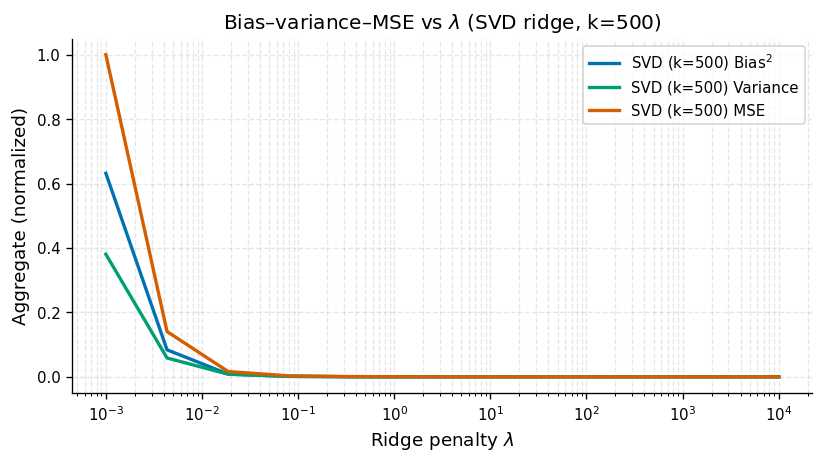

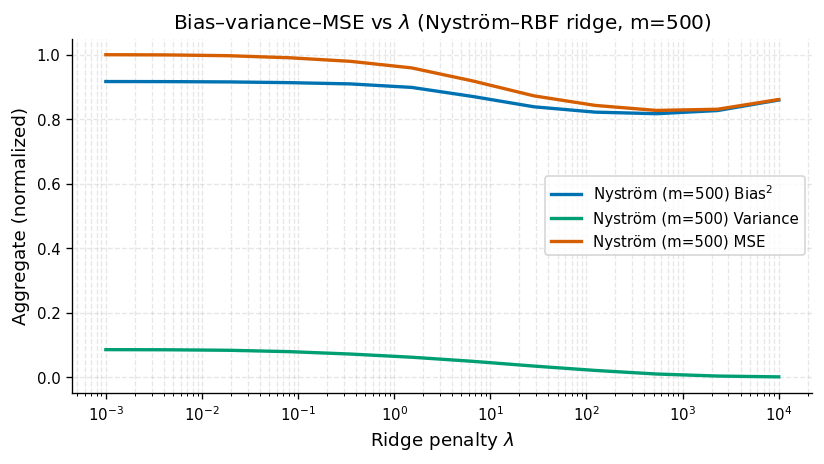

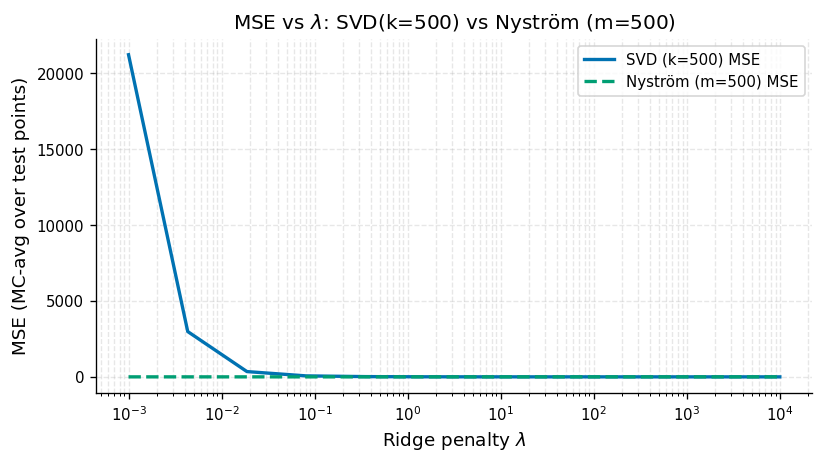

In [308]:

# ==========================================================
# 7. Runtime: NE, truncated-SVD, GD-in-SVD, Nyström-NE
# ==========================================================
def ridge_ne(alpha):
    """
    Ridge via normal equations on standardized X_std_global:
        (X^T X + alpha I) beta = X^T y_c
    """
    A = XtX_b + alpha * np.eye(p_svd)
    beta = np.linalg.solve(A, Xty_b)
    intercept = y_mean_global
    return beta, intercept

def ridge_svd_trunc(alpha):
    """
    Ridge via truncated SVD in top-k singular directions:
        beta = V_k diag(s_k/(s_k^2 + alpha)) U_k^T y_c
    """
    d = s_k / (s_k**2 + alpha)       # length-k
    beta = V_k @ (d * (U_k.T @ y_c_global))
    intercept = y_mean_global
    return beta, intercept

def ridge_gd_svd(alpha, eta=1e-3, max_iter=200):
    """
    Ridge via gradient descent in the top-k singular subspace.
    Solve for theta in R^k in:
        (1/2n)||y_c - Z_k theta||^2 + alpha/2 ||theta||^2,
    then beta = V_k theta.
    """
    n_loc, k_loc = Z_k.shape
    theta = np.zeros(k_loc)

    for _ in range(max_iter):
        resid = Z_k @ theta - y_c_global
        grad  = (Z_k.T @ resid) / n_loc + alpha * theta
        theta -= eta * grad

    beta = V_k @ theta
    intercept = y_mean_global
    return beta, intercept

def ridge_nystrom_ne(alpha):
    """
    Ridge via normal equations in Nyström feature space Z_bench:
        (Z^T Z + alpha I) w = Z^T y_c
    """
    A = ZtZ_b + alpha * np.eye(m_bench)
    w = np.linalg.solve(A, Zty_b)
    intercept = y_mean_global
    return w, intercept

def time_fn(fn, *args, n_repeat=3, **kwargs):
    times = []
    for _ in range(n_repeat):
        t0 = perf_counter()
        fn(*args, **kwargs)
        times.append(perf_counter() - t0)
    return float(np.mean(times))

alpha_poly = float(best_alpha_poly)
alpha_nys  = float(best_alpha_nys)

print("alpha_poly =", alpha_poly)
print("alpha_nys  =", alpha_nys)

t_ne   = time_fn(ridge_ne,          alpha_poly)
t_svd  = time_fn(ridge_svd_trunc,   alpha_poly)
t_gd   = time_fn(ridge_gd_svd,      alpha_poly, eta=1e-3, max_iter=200)
t_nys  = time_fn(ridge_nystrom_ne,  alpha_nys)

print(f"[Benchmark] Normal-equation ridge (poly, full rank): {t_ne:.3f} s")
print(f"[Benchmark] Truncated-SVD ridge (poly, k={k_eff}):   {t_svd:.3f} s")
print(f"[Benchmark] GD  (poly, k={k_eff}):    {t_gd:.3f} s")
print(f"[Benchmark] Nyström–RBF ridge (m={NYSTROM_COMPONENTS}): {t_nys:.3f} s")

def mse_on_train_poly(beta, intercept):
    y_hat = X_std_global @ beta + intercept
    return np.mean((y_hat - y)**2)

beta_ne,  int_ne  = ridge_ne(alpha_poly)
beta_svd, int_svd = ridge_svd_trunc(alpha_poly)
beta_gd,  int_gd  = ridge_gd_svd(alpha_poly, eta=1e-3, max_iter=200)

print("Train MSE NE   :", mse_on_train_poly(beta_ne,  int_ne))
print("Train MSE SVD  :", mse_on_train_poly(beta_svd, int_svd))
print("Train MSE GD(k):", mse_on_train_poly(beta_gd,  int_gd))

def mse_on_train_nys(w, intercept):
    y_hat = Z_bench @ w + intercept
    return np.mean((y_hat - y)**2)

w_nys, int_nys = ridge_nystrom_ne(alpha_nys)
print("Train MSE Nyström:", mse_on_train_nys(w_nys, int_nys))

# ==========================================================
# 8. Bias^2, variance, MSE vs lambda (SVD/GD, k=500 & Nyström, m=500)
# ==========================================================
rng_lam = default_rng(321)

n_samples = y.shape[0]
assert Z_k.shape[0] == n_samples
assert Z_bench.shape[0] == n_samples

# Fix a common test set
n_test_lam   = 1000
test_idx_lam = rng_lam.choice(n_samples, size=n_test_lam, replace=False)
train_pool_lam = np.setdiff1d(np.arange(n_samples), test_idx_lam)

Zk_test = Z_k[test_idx_lam]      # (n_test, 500)
Zn_test = Z_bench[test_idx_lam]  # (n_test, 500)
y_test  = y[test_idx_lam]

B_lam       = 30        # Monte Carlo repetitions
n_train_lam = 3000      # training size per repetition
alpha_grid  = alphas    # same λ grid as before
n_alpha     = len(alpha_grid)

# preds_svd[a, b, j] = prediction at alpha[a], replicate b, test point j
pred_svd = np.zeros((n_alpha, B_lam, n_test_lam))
pred_nys = np.zeros((n_alpha, B_lam, n_test_lam))

for b in range(B_lam):
    train_idx = rng_lam.choice(train_pool_lam, size=n_train_lam, replace=False)
    Zk_tr = Z_k[train_idx]
    Zn_tr = Z_bench[train_idx]
    y_tr  = y[train_idx]

    y_mean_tr = y_tr.mean()
    y_c_tr    = y_tr - y_mean_tr

    # Standardize SVD and Nyström features on this train split
    scaler_Zk = StandardScaler(with_mean=True, with_std=True)
    Zk_tr_sc  = scaler_Zk.fit_transform(Zk_tr)
    Zk_te_sc  = scaler_Zk.transform(Zk_test)

    scaler_Zn = StandardScaler(with_mean=True, with_std=True)
    Zn_tr_sc  = scaler_Zn.fit_transform(Zn_tr)
    Zn_te_sc  = scaler_Zn.transform(Zn_test)

    # Precompute Gram matrices for this split
    XtX_k = Zk_tr_sc.T @ Zk_tr_sc
    Xty_k = Zk_tr_sc.T @ y_c_tr

    XtX_n = Zn_tr_sc.T @ Zn_tr_sc
    Xty_n = Zn_tr_sc.T @ y_c_tr

    for i, alpha in enumerate(alpha_grid):
        # --- Ridge in 500-dim SVD subspace (solution that GD would converge to) ---
        A_k = XtX_k + alpha * np.eye(XtX_k.shape[0])
        w_k = np.linalg.solve(A_k, Xty_k)
        pred_svd[i, b, :] = Zk_te_sc @ w_k + y_mean_tr

        # --- Ridge in 500-dim Nyström feature space ---
        A_n = XtX_n + alpha * np.eye(XtX_n.shape[0])
        w_n = np.linalg.solve(A_n, Xty_n)
        pred_nys[i, b, :] = Zn_te_sc @ w_n + y_mean_tr

    if (b + 1) % 5 == 0:
        print(f"[lambda-BV] finished replicate {b+1}/{B_lam}")

def bv_curves(pred, y_true):
    """
    pred: (n_alpha, B, n_test)
    y_true: (n_test,)
    returns arrays of length n_alpha: bias^2, var, mse
    """
    mean_pred = pred.mean(axis=1)                      # n_alpha × n_test
    bias2 = ((mean_pred - y_true)**2).mean(axis=1)
    var   = pred.var(axis=1, ddof=1).mean(axis=1)     # average over test points
    mse   = ((pred - y_true)**2).mean(axis=(1, 2))    # average over reps & test
    return bias2, var, mse

bias2_svd_l, var_svd_l, mse_svd_l = bv_curves(pred_svd, y_test)
bias2_nys_l, var_nys_l, mse_nys_l = bv_curves(pred_nys, y_test)

# --- Normalized curves (like your GD figure) ---
mse_max_svd = mse_svd_l.max()
mse_max_nys = mse_nys_l.max()

bias2_svd_norm = bias2_svd_l / mse_max_svd
var_svd_norm   = var_svd_l   / mse_max_svd
mse_svd_norm   = mse_svd_l   / mse_max_svd

bias2_nys_norm = bias2_nys_l / mse_max_nys
var_nys_norm   = var_nys_l   / mse_max_nys
mse_nys_norm   = mse_nys_l   / mse_max_nys

# 8.1 SVD/GD (k=500) bias–variance–MSE vs λ
plt.figure(figsize=(7, 4))
plt.semilogx(alpha_grid, bias2_svd_norm, label=r"SVD (k=500) Bias$^2$")
plt.semilogx(alpha_grid, var_svd_norm,   label=r"SVD (k=500) Variance")
plt.semilogx(alpha_grid, mse_svd_norm,   label=r"SVD (k=500) MSE")
plt.xlabel(r"Ridge penalty $\lambda$")
plt.ylabel("Aggregate (normalized)")
plt.title("Bias–variance–MSE vs $\\lambda$ (SVD ridge, k=500)")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 8.2 Nyström (m=500) bias–variance–MSE vs λ
plt.figure(figsize=(7, 4))
plt.semilogx(alpha_grid, bias2_nys_norm, label=r"Nyström (m=500) Bias$^2$")
plt.semilogx(alpha_grid, var_nys_norm,   label=r"Nyström (m=500) Variance")
plt.semilogx(alpha_grid, mse_nys_norm,   label=r"Nyström (m=500) MSE")
plt.xlabel(r"Ridge penalty $\lambda$")
plt.ylabel("Aggregate (normalized)")
plt.title("Bias–variance–MSE vs $\\lambda$ (Nyström–RBF ridge, m=500)")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 8.3 Optional: raw MSE vs λ comparison
plt.figure(figsize=(7, 4))
plt.semilogx(alpha_grid, mse_svd_l, label="SVD (k=500) MSE")
plt.semilogx(alpha_grid, mse_nys_l, label="Nyström (m=500) MSE", linestyle="--")
plt.xlabel(r"Ridge penalty $\lambda$")
plt.ylabel("MSE (MC-avg over test points)")
plt.title("MSE vs $\\lambda$: SVD(k=500) vs Nyström (m=500)")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

[GD-iter] Using Z_k with shape (n=5000, k=500)
[GD-iter] B=30, n_train=3000, n_test=800, T_max=400, alpha=0.0, eta=0.001
[GD-iter] finished replicate 5/30
[GD-iter] finished replicate 10/30
[GD-iter] finished replicate 15/30
[GD-iter] finished replicate 20/30
[GD-iter] finished replicate 25/30
[GD-iter] finished replicate 30/30


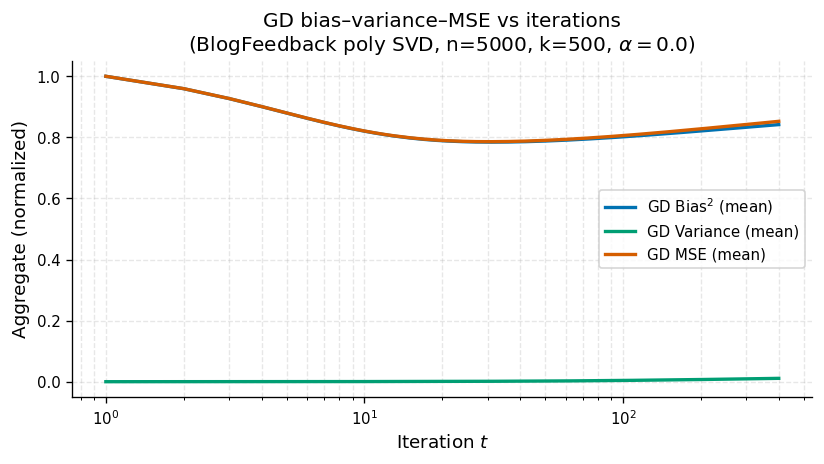

In [309]:
# ==========================================================
# 9. GD bias–variance–MSE vs iteration (implicit regularization)
#    – uses the same SVD subspace Z_k (k = 500)
# ==========================================================
from numpy.random import default_rng

rng_gd_iter = default_rng(987)

n_samples_gd, k_dim_gd = Z_k.shape
print(f"[GD-iter] Using Z_k with shape (n={n_samples_gd}, k={k_dim_gd})")

# Test / train split (reused across all iterations and reps)
n_test_gd   = 800
test_idx_gd = rng_gd_iter.choice(n_samples_gd, size=n_test_gd, replace=False)
train_pool_gd = np.setdiff1d(np.arange(n_samples_gd), test_idx_gd)

Z_test_gd = Z_k[test_idx_gd]
y_test_gd = y[test_idx_gd]

# Monte Carlo and GD settings
B_iter      = 30      # number of Monte Carlo repetitions
n_train_gd  = 3000    # training size per repetition
T_max       = 400     # max GD iterations
alpha_gd_it = 0.0     # NO explicit ridge: implicit reg purely from early stopping
eta_gd_it   = 1e-3    # step size (works well at this scale)

print(f"[GD-iter] B={B_iter}, n_train={n_train_gd}, n_test={n_test_gd}, "
      f"T_max={T_max}, alpha={alpha_gd_it}, eta={eta_gd_it}")

# preds_gd_iter[b, t, i] = prediction at MC rep b, iteration t, test point i
preds_gd_iter = np.zeros((B_iter, T_max, n_test_gd), dtype=float)

for b in range(B_iter):
    # fresh train sample each repetition
    train_idx = rng_gd_iter.choice(train_pool_gd, size=n_train_gd, replace=False)
    Z_tr = Z_k[train_idx]       # (n_train_gd × k_dim_gd)
    y_tr = y[train_idx]

    n_tr = Z_tr.shape[0]
    y_mean_tr = y_tr.mean()
    y_c_tr    = y_tr - y_mean_tr

    # initialize GD in SVD subspace
    theta = np.zeros(k_dim_gd)

    for t in range(T_max):
        # gradient of (1/2n)||y_c - Z theta||^2 + (alpha/2)||theta||^2
        resid = Z_tr @ theta - y_c_tr
        grad  = (Z_tr.T @ resid) / n_tr + alpha_gd_it * theta
        theta -= eta_gd_it * grad

        # predictions on fixed test set at iteration t
        preds_gd_iter[b, t, :] = Z_test_gd @ theta + y_mean_tr

    if (b + 1) % 5 == 0:
        print(f"[GD-iter] finished replicate {b+1}/{B_iter}")

# ---- Compute bias^2, variance, MSE across iterations ----
# mean over MC reps
mean_pred_iter = preds_gd_iter.mean(axis=0)              # (T_max × n_test_gd)

bias2_iter = ((mean_pred_iter - y_test_gd)**2).mean(axis=1)         # length T_max
var_iter   = preds_gd_iter.var(axis=0, ddof=1).mean(axis=1)         # length T_max
mse_iter   = ((preds_gd_iter - y_test_gd)**2).mean(axis=(0, 2))     # length T_max

# normalize by max MSE for nicer plotting
mse_max_iter    = mse_iter.max()
bias2_iter_norm = bias2_iter / mse_max_iter
var_iter_norm   = var_iter   / mse_max_iter
mse_iter_norm   = mse_iter   / mse_max_iter

t_grid = np.arange(1, T_max + 1)

plt.figure(figsize=(7, 4))
plt.semilogx(t_grid, bias2_iter_norm, label=r"GD Bias$^2$ (mean)")
plt.semilogx(t_grid, var_iter_norm,   label="GD Variance (mean)")
plt.semilogx(t_grid, mse_iter_norm,   label="GD MSE (mean)")

plt.xlabel("Iteration $t$")
plt.ylabel("Aggregate (normalized)")
plt.title(
    "GD bias–variance–MSE vs iterations\n"
    f"(BlogFeedback poly SVD, n={n_samples_gd}, k={k_dim_gd}, "
    r"$\alpha=$" + f"{alpha_gd_it})"
)
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()





# Explanotory Data Analysis

=== BASIC SHAPES ===
Full X_full shape       : (52397, 280)
Subsampled X_base shape : (5000, 280)
Chosen 60-D X_sub shape : (5000, 60)
Poly design X_poly shape: (5000, 1890)
y_raw shape             : (52397,)
y (log1p subsample)     : (5000,)

=== TARGET SUMMARY: RAW COMMENTS ===
Min   : 0
Max   : 1424
Mean  : 6.76
Std   : 37.71
50th pct: 0
75th pct: 1
90th pct: 8
95th pct: 23
99th pct: 153

=== TARGET SUMMARY: log(1 + comments) ON SUBSAMPLE ===
Min   : 0.000
Max   : 6.737
Mean  : 0.668
Std   : 1.138
 5th pct: 0.000
25th pct: 0.000
50th pct: 0.000
75th pct: 1.099
95th pct: 3.219



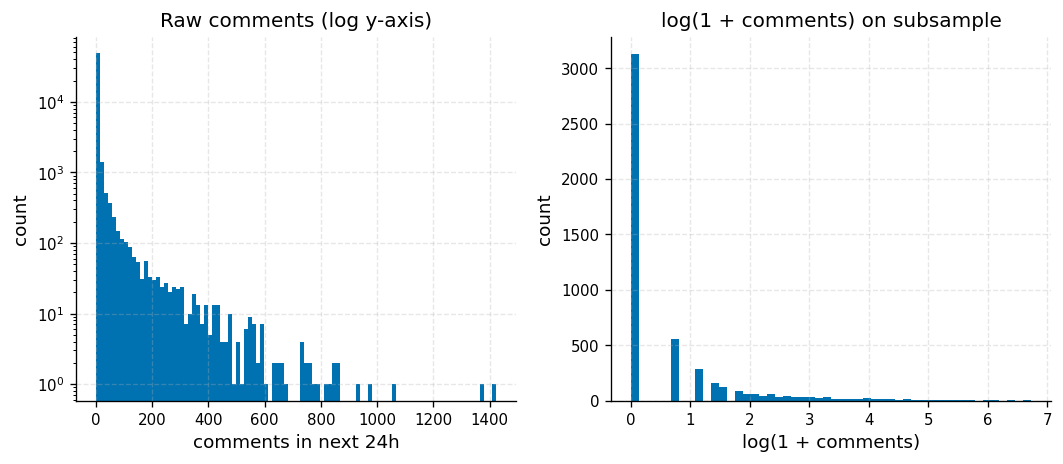

=== BASE FEATURE SUMMARY (60 columns used in poly) ===
Top 15 base features by |corr with y|:
    local_idx  orig_col        mean         std  frac_zero       skew  \
0          50         3  346.147600  446.720163     0.0372   2.058365   
1          33        10   14.251313   28.853370     0.0400   4.703833   
2          35         6   28.381676   38.704012     0.0372   2.881498   
3          22        16   42.113585   52.726652     0.0488   2.059832   
4          40         5   15.446486   32.570762     0.0372   5.003694   
5          28        18  290.644400  377.908568     0.0450   2.104555   
6          59        13  260.470600  322.186307     0.0400   1.863694   
7          26        23  255.982600  320.923327     0.0374   1.883395   
8           4        19   22.250300   61.980475     0.3122   5.312563   
9          19        22 -229.255000  268.403554     0.0430  -1.522603   
10         13        20    1.195173    4.070131     0.1196   6.502785   
11         25        31    0.5

/Users/ad/Desktop/Do not open/GMU/STAT 676/Project/.project/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/ad/Desktop/Do not open/GMU/STAT 676/Project/.project/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


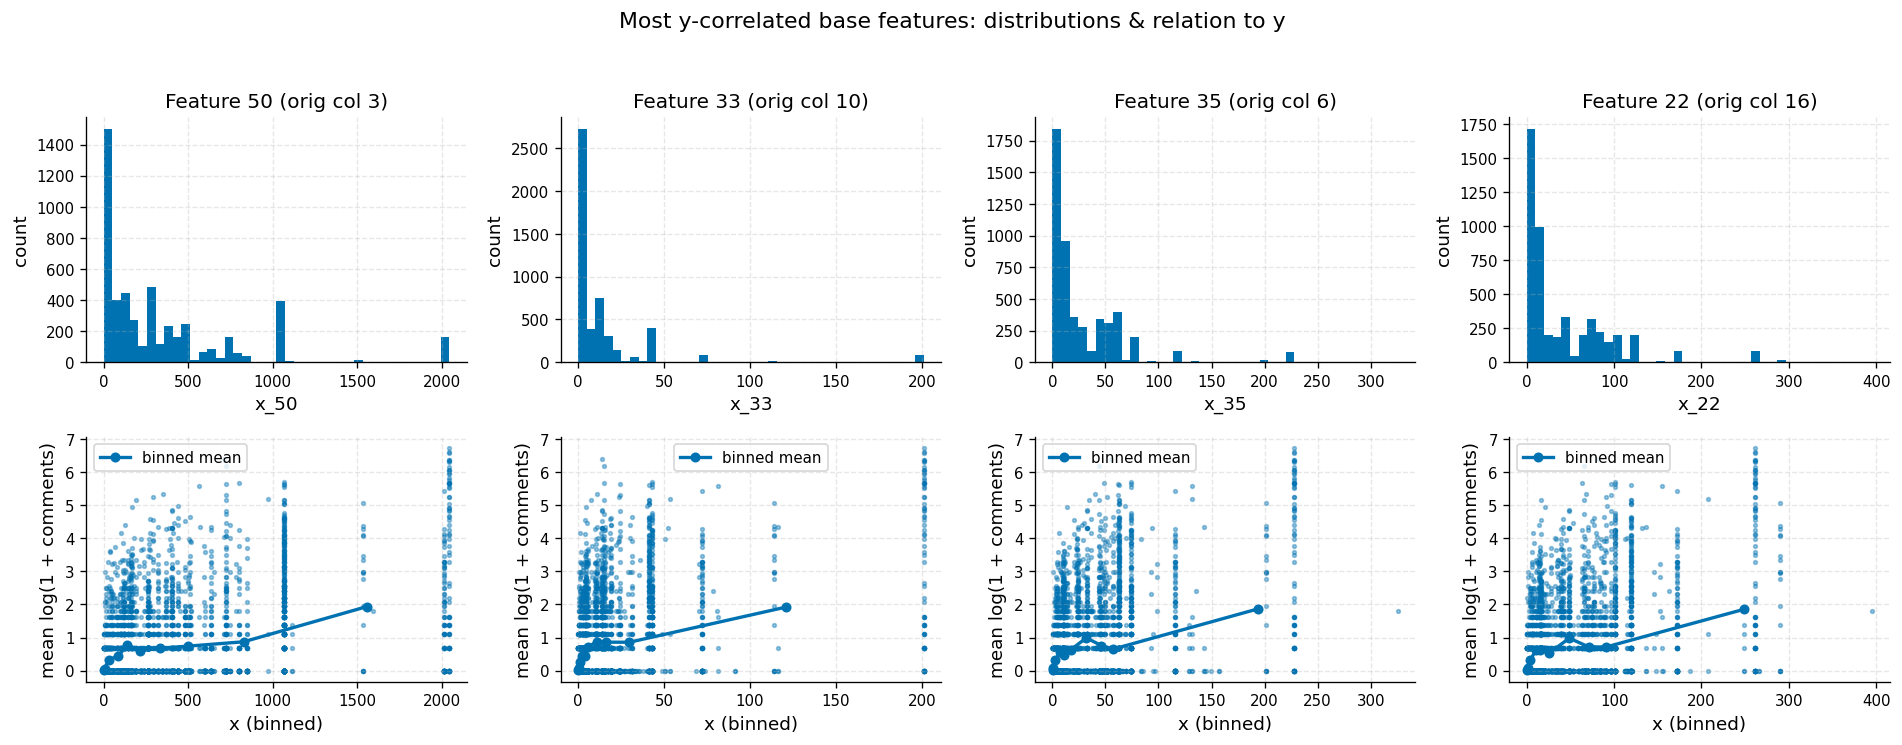

=== FEATURE–FEATURE CORRELATIONS (first 20 base features) ===


/Users/ad/Desktop/Do not open/GMU/STAT 676/Project/.project/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/ad/Desktop/Do not open/GMU/STAT 676/Project/.project/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


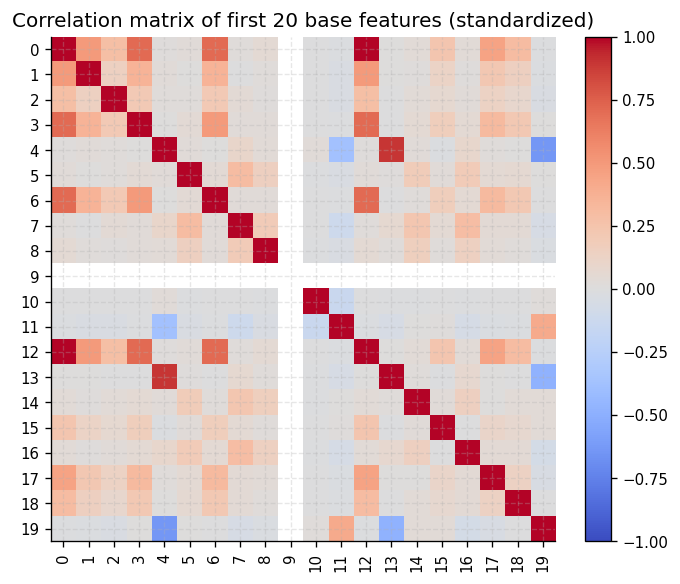

<Figure size 840x840 with 0 Axes>

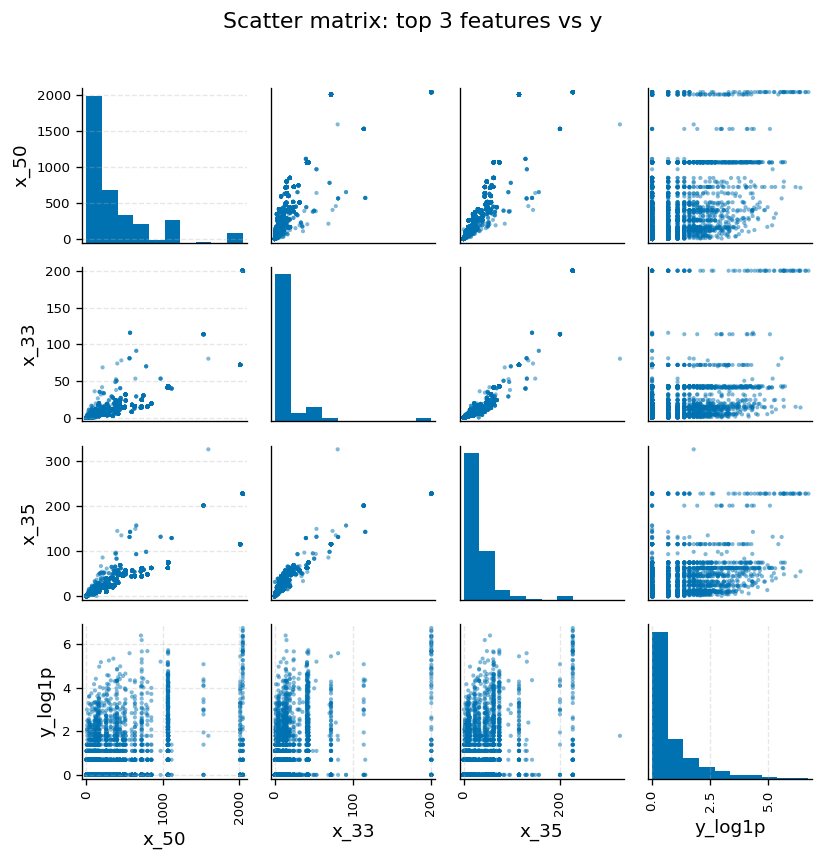

=== SPARSITY / SCALE CHECKS ===
Fraction of zeros in full X_full : 0.834
Fraction of zeros in X_base      : 0.832
Fraction of zeros in 60-D X_sub  : 0.760



/var/folders/z8/31vxr9cj5rz9qf_k9kps2rs40000gn/T/ipykernel_53648/2177233749.py:211: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(X_sub_std[:, feat_box],


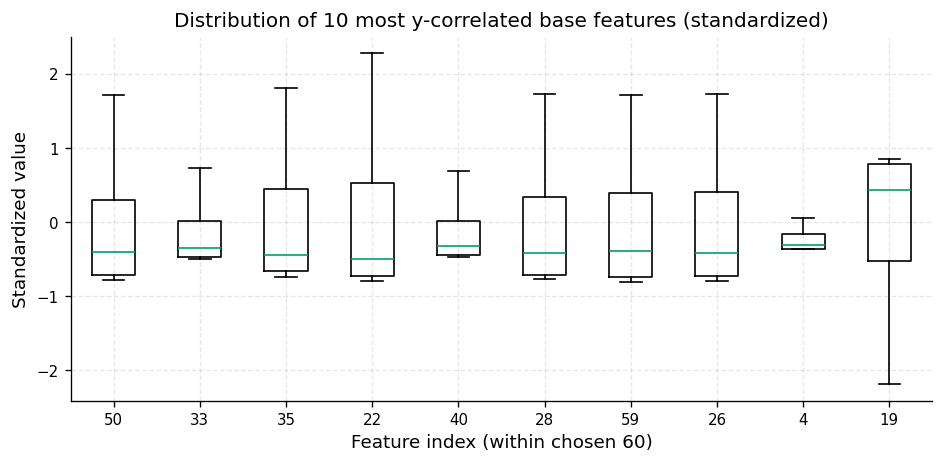

=== SINGULAR VALUE STRUCTURE: BASE vs POLY DESIGN ===
Base design singular values (first 5): [249.37904691 227.6658843  131.44648435  89.41764119  80.29269928]
Poly design singular values (first 5): [2070.71981834  787.05803419  397.97987387  359.62939016  306.17037864]



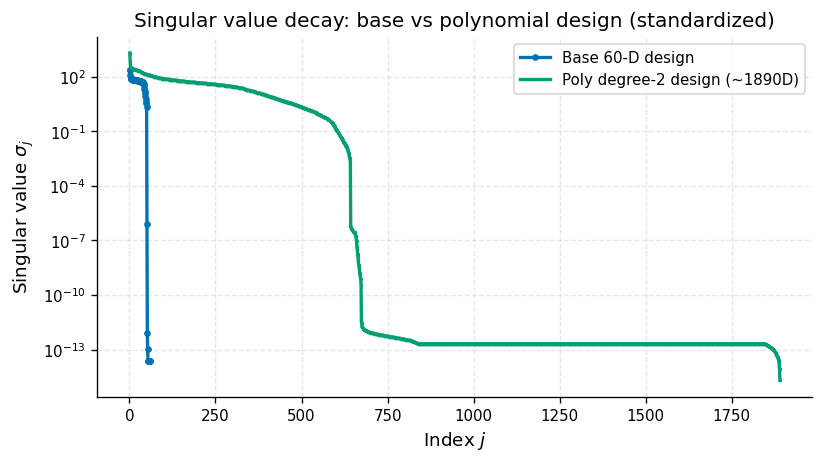

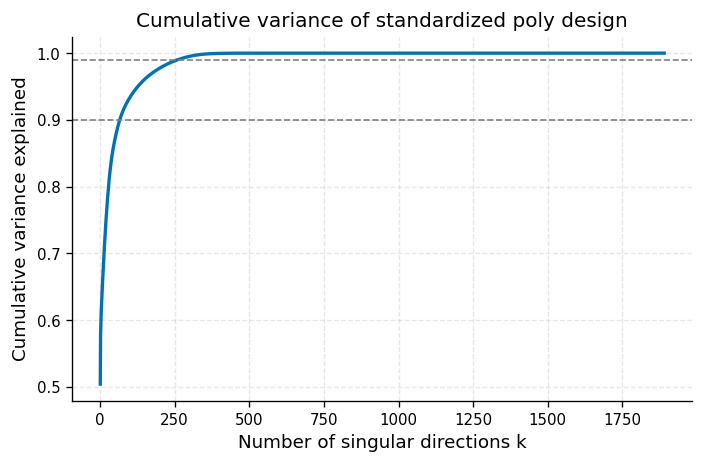

Directions needed for 90% variance: k ≈ 67
Directions needed for 99% variance: k ≈ 260

Row norm summary for standardized poly design:
  min : 5.151
  max : 2069.215
  mean: 18.383
  std : 36.920



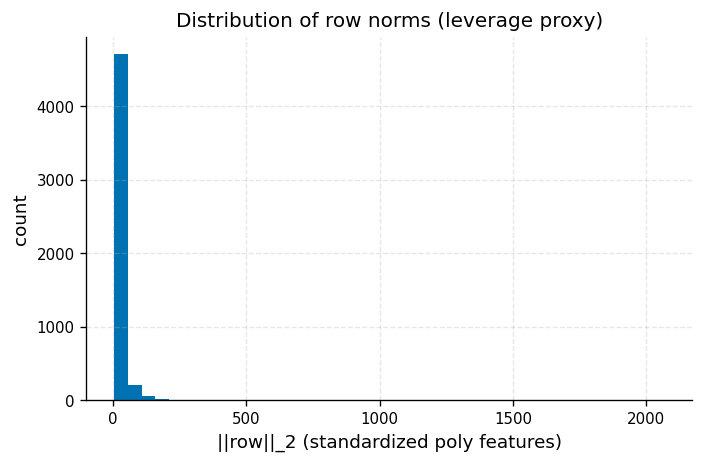

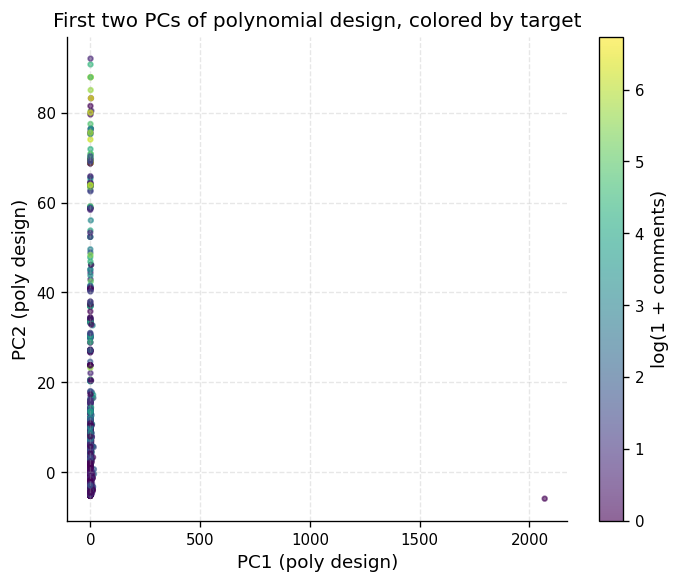

In [310]:
# ==========================================================
# EXPLORATORY DATA ANALYSIS for BlogFeedback subset
# (run AFTER building X_full, y_raw, y_full, X_base, y, X_sub, X_poly)
# ==========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import svd
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix

plt.rcParams["figure.dpi"] = 120

# ----------------------------------------------------------
# 0. Basic shapes
# ----------------------------------------------------------
print("=== BASIC SHAPES ===")
print(f"Full X_full shape       : {X_full.shape}")
print(f"Subsampled X_base shape : {X_base.shape}")
print(f"Chosen 60-D X_sub shape : {X_sub.shape}")
print(f"Poly design X_poly shape: {X_poly.shape}")
print(f"y_raw shape             : {y_raw.shape}")
print(f"y (log1p subsample)     : {y.shape}")
print()

# ----------------------------------------------------------
# 1. Target distribution: raw vs log1p
# ----------------------------------------------------------
print("=== TARGET SUMMARY: RAW COMMENTS ===")
print(f"Min   : {y_raw.min():.0f}")
print(f"Max   : {y_raw.max():.0f}")
print(f"Mean  : {y_raw.mean():.2f}")
print(f"Std   : {y_raw.std():.2f}")
for q in [50, 75, 90, 95, 99]:
    print(f"{q:>2}th pct: {np.percentile(y_raw, q):.0f}")
print()

print("=== TARGET SUMMARY: log(1 + comments) ON SUBSAMPLE ===")
print(f"Min   : {y.min():.3f}")
print(f"Max   : {y.max():.3f}")
print(f"Mean  : {y.mean():.3f}")
print(f"Std   : {y.std():.3f}")
for q in [5, 25, 50, 75, 95]:
    print(f"{q:>2}th pct: {np.percentile(y, q):.3f}")
print()

fig, axes = plt.subplots(1, 2, figsize=(9, 4))

axes[0].hist(y_raw, bins=100, log=True)
axes[0].set_title("Raw comments (log y-axis)")
axes[0].set_xlabel("comments in next 24h")
axes[0].set_ylabel("count")

axes[1].hist(y, bins=50)
axes[1].set_title("log(1 + comments) on subsample")
axes[1].set_xlabel("log(1 + comments)")
axes[1].set_ylabel("count")

plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# 2. Summary table for the 60 base features used in the poly expansion
# ----------------------------------------------------------
print("=== BASE FEATURE SUMMARY (60 columns used in poly) ===")

# Standardise X_sub for correlation/skew
scaler_base = StandardScaler(with_mean=True, with_std=True)
X_sub_std = scaler_base.fit_transform(X_sub)

base_stats = []
for j in range(X_sub.shape[1]):
    x = X_sub[:, j]
    x_std = X_sub_std[:, j]

    mean = x.mean()
    std  = x.std()
    xmin = x.min()
    xmax = x.max()
    frac_zero = np.mean(x == 0.0)

    # simple skewness estimate
    if std > 0:
        skew = np.mean(((x - mean) / std) ** 3)
    else:
        skew = np.nan

    # correlation with y
    corr = np.corrcoef(x_std, (y - y.mean()) / y.std())[0, 1]

    base_stats.append(
        dict(
            local_idx=j,
            orig_col=idx_feats[j],  # original column index in X_full
            mean=mean,
            std=std,
            min=xmin,
            max=xmax,
            frac_zero=frac_zero,
            skew=skew,
            corr_y=corr,
            abs_corr_y=abs(corr),
        )
    )

df_base_stats = (
    pd.DataFrame(base_stats)
      .sort_values("abs_corr_y", ascending=False)
      .reset_index(drop=True)
)

print("Top 15 base features by |corr with y|:")
print(df_base_stats.loc[:14, ["local_idx", "orig_col", "mean", "std",
                              "frac_zero", "skew", "corr_y"]])
print()

# ----------------------------------------------------------
# 3. Visualize top features vs y + binned means (nonlinearity check)
# ----------------------------------------------------------
def plot_binned_relation(x, y, ax, nbins=10, label=None):
    """
    Plot mean y within quantile bins of x to see nonlinearity.
    """
    q_edges = np.linspace(0, 100, nbins + 1)
    edges = np.percentile(x, q_edges)
    mids = 0.5 * (edges[:-1] + edges[1:])
    y_bin = []

    for k in range(nbins):
        mask = (x >= edges[k]) & (x <= edges[k+1]) if k == nbins-1 else \
               (x >= edges[k]) & (x <  edges[k+1])
        if np.any(mask):
            y_bin.append(y[mask].mean())
        else:
            y_bin.append(np.nan)

    ax.plot(mids, y_bin, marker="o", label=label)
    ax.set_xlabel("x (binned)")
    ax.set_ylabel("mean log(1 + comments)")

# top 4 most correlated base features
top4 = df_base_stats["local_idx"].values[:4]

fig, axes = plt.subplots(2, 4, figsize=(16, 6))

for k, j in enumerate(top4):
    x = X_sub[:, j]

    # raw histogram
    axes[0, k].hist(x, bins=40)
    axes[0, k].set_title(f"Feature {j} (orig col {idx_feats[j]})")
    axes[0, k].set_xlabel(f"x_{j}")
    axes[0, k].set_ylabel("count")

    # scatter vs y
    axes[1, k].scatter(x, y, s=5, alpha=0.4)
    plot_binned_relation(x, y, axes[1, k], nbins=10, label="binned mean")
    axes[1, k].legend()

plt.suptitle("Most y-correlated base features: distributions & relation to y", y=1.03)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# 4. Feature–feature correlations (multicollinearity)
# ----------------------------------------------------------
print("=== FEATURE–FEATURE CORRELATIONS (first 20 base features) ===")

subset_for_corr = min(20, X_sub_std.shape[1])
X_corr = X_sub_std[:, :subset_for_corr]
corr_mat = np.corrcoef(X_corr, rowvar=False)

plt.figure(figsize=(7, 5))
im = plt.imshow(corr_mat, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title(f"Correlation matrix of first {subset_for_corr} base features (standardized)")
plt.xticks(range(subset_for_corr), range(subset_for_corr), rotation=90)
plt.yticks(range(subset_for_corr), range(subset_for_corr))
plt.tight_layout()
plt.show()

# simple scatter-matrix for the 3 most y-correlated features + y
top3 = df_base_stats["local_idx"].values[:3]
df_pair = pd.DataFrame(
    {
        f"x_{j}": X_sub[:, j] for j in top3
    } | {"y_log1p": y}
)

plt.figure(figsize=(7, 7))
scatter_matrix(df_pair, diagonal="hist", figsize=(7, 7))
plt.suptitle("Scatter matrix: top 3 features vs y", y=1.02)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# 5. Sparsity / scale diagnostics
# ----------------------------------------------------------
print("=== SPARSITY / SCALE CHECKS ===")
frac_zero_full = (X_full == 0).mean()
frac_zero_base = (X_base == 0).mean()
frac_zero_sub  = (X_sub == 0).mean()

print(f"Fraction of zeros in full X_full : {frac_zero_full:.3f}")
print(f"Fraction of zeros in X_base      : {frac_zero_base:.3f}")
print(f"Fraction of zeros in 60-D X_sub  : {frac_zero_sub:.3f}")
print()

feat_box = df_base_stats["local_idx"].values[:10]  # 10 most y-correlated features
plt.figure(figsize=(8, 4))
plt.boxplot(X_sub_std[:, feat_box],
            labels=[f"{j}" for j in feat_box],
            showfliers=False)
plt.xlabel("Feature index (within chosen 60)")
plt.ylabel("Standardized value")
plt.title("Distribution of 10 most y-correlated base features (standardized)")
plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# 6. Singular value structure: base vs polynomial design
# ----------------------------------------------------------
print("=== SINGULAR VALUE STRUCTURE: BASE vs POLY DESIGN ===")

# Base design (60-D)
X_base_std = StandardScaler(with_mean=True, with_std=True).fit_transform(X_sub)
U_base, s_base, Vt_base = svd(X_base_std, full_matrices=False)

# Polynomial design (~1890-D)
X_poly_std = StandardScaler(with_mean=True, with_std=True).fit_transform(X_poly)
U_poly, s_poly, Vt_poly = svd(X_poly_std, full_matrices=False)

print(f"Base design singular values (first 5): {s_base[:5]}")
print(f"Poly design singular values (first 5): {s_poly[:5]}")
print()

# singular value decay
plt.figure(figsize=(7, 4))
plt.semilogy(range(1, len(s_base) + 1), s_base,
             marker="o", markersize=3, label="Base 60-D design")
plt.semilogy(range(1, len(s_poly) + 1), s_poly,
             marker=".", markersize=2, label="Poly degree-2 design (~1890D)")
plt.xlabel("Index $j$")
plt.ylabel("Singular value $\\sigma_j$")
plt.title("Singular value decay: base vs polynomial design (standardized)")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# cumulative explained variance (energy) for poly design
sv2_poly = s_poly**2
var_poly = sv2_poly / sv2_poly.sum()
cum_var_poly = np.cumsum(var_poly)

plt.figure(figsize=(6, 4))
plt.plot(range(1, len(cum_var_poly)+1), cum_var_poly)
plt.axhline(0.90, color="gray", linestyle="--", linewidth=1)
plt.axhline(0.99, color="gray", linestyle="--", linewidth=1)
plt.xlabel("Number of singular directions k")
plt.ylabel("Cumulative variance explained")
plt.title("Cumulative variance of standardized poly design")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

k90 = np.searchsorted(cum_var_poly, 0.90) + 1
k99 = np.searchsorted(cum_var_poly, 0.99) + 1
print(f"Directions needed for 90% variance: k ≈ {k90}")
print(f"Directions needed for 99% variance: k ≈ {k99}")
print()

# ----------------------------------------------------------
# 7. Row norms / leverage diagnostics for poly design
# ----------------------------------------------------------
row_norms = np.linalg.norm(X_poly_std, axis=1)
print("Row norm summary for standardized poly design:")
print(f"  min : {row_norms.min():.3f}")
print(f"  max : {row_norms.max():.3f}")
print(f"  mean: {row_norms.mean():.3f}")
print(f"  std : {row_norms.std():.3f}")
print()

plt.figure(figsize=(6, 4))
plt.hist(row_norms, bins=40)
plt.xlabel("||row||_2 (standardized poly features)")
plt.ylabel("count")
plt.title("Distribution of row norms (leverage proxy)")
plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# 8. PCA view: first two PCs of poly design, colored by y
# ----------------------------------------------------------
# PCs from SVD: PC_j = U[:, j] * s_j
PC1 = U_poly[:, 0] * s_poly[0]
PC2 = U_poly[:, 1] * s_poly[1]

plt.figure(figsize=(6, 5))
sc = plt.scatter(PC1, PC2, c=y, s=8, cmap="viridis", alpha=0.6)
plt.colorbar(sc, label="log(1 + comments)")
plt.xlabel("PC1 (poly design)")
plt.ylabel("PC2 (poly design)")
plt.title("First two PCs of polynomial design, colored by target")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# (Optional) keep these for downstream spectral methods
X_poly_std_global = X_poly_std
U_poly_global, s_poly_global, Vt_poly_global = U_poly, s_poly, Vt_poly
